# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [283]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8) )",   # needed for the fakes            
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            
#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "msoftdrop": "fj_mass<40",
#             "met": "met_pt>20",

#             "bveto": "n_bjets_T>0",
        },
        "ele": {
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            
#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.02))",
#             "bveto": "n_bjets_T>0",
        },
}

channels = [
    "ele",
    "mu",
]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "DYJets",
    "WZQQ",

    "Data",
    "Fake",
]

years = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

### 2017 is good
### 2018 ele is good, 2018 mu doesnt exist
### 2016 ele is good, mu a bit weird but not awful
### 2016APV is good

In [284]:
events_dict = {}

In [285]:
samples_dir = {
    
#     "2016":    "../eos/Oct10_hww_2016",
#     "2016APV": "../eos/Oct10_hww_2016APV",
#     "2017":    "../eos/Oct10_hww_2017",
#     "2018":    "../eos/Oct10_hww_2018",

    "2016":    "../eos/Dec20_hww_2016",
    "2016APV": "../eos/Dec20_hww_2016APV",
    "2017":    "../eos/Dec20_hww_2017",
    "2018":    "../eos/Dec20_hww_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path, fake_SF={"ele": 0.75, "mu": 1})

INFO:root:Finding fake_2016_ele_EWK_SF_Down.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016_ele_EWK_SF_Down.parquet
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 19 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 12 events
INFO:root:tot event weight 18.89102229308931 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying msoftdrop selection on 1032 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 808 events
INFO:root:tot event weight 192.62006684675464 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data


INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying msoftdrop selection on 221 events
INFO:root:Will fill the QCD dataframe with the remaining 179 events
INFO:root:tot event weight 0.005573070019926829 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 39 events
INFO:root:Will fill the WZQQ dataframe with the remaining 24 events
INFO:root:tot event weight 8.273815144548077 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 84 events
INFO:root:Will fill the Diboson dataframe with the remaining 74 events
INFO:root:tot event weight 18.749629975085487 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 700 events
INFO:root:Will fill the TTbar dataframe with the remaining 

INFO:root:Will fill the EWKvjets dataframe with the remaining 878 events
INFO:root:tot event weight 200.34943997332766 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data
INFO:root:Applying lepmiso selection on 22084 events
INFO:root:Applying msoftdrop selection on 22084 events
INFO:root:Will fill the Data dataframe with the remaining 18390 events
INFO:root:tot event weight 18390.0 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying lepmiso selection on 1544 events
INFO:root:Applying msoftdrop selection on 1544 events
INFO:root:Will fill the WH dataframe with the remaining 1283 events
INFO:root:tot event weight 1.1592067914150437 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 61502 events
INFO:root:Applying msoftdrop selection on 61502 events
INFO:

INFO:root:Applying msoftdrop selection on 57160 events
INFO:root:Will fill the TTbar dataframe with the remaining 53390 events
INFO:root:tot event weight 1268.9022523607723 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying lepmiso selection on 284 events
INFO:root:Applying msoftdrop selection on 284 events
INFO:root:Will fill the QCD dataframe with the remaining 239 events
INFO:root:tot event weight 0.006668732214020484 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 65 events
INFO:root:Applying msoftdrop selection on 65 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 56 events
INFO:root:tot event weight 1.730426625973983 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 57 events
INFO:root:Applying msoftdrop selection on 57 events
INFO:root:Will fill the WZQQ dataframe with

INFO:root:Applying msoftdrop selection on 444 events
INFO:root:Will fill the Diboson dataframe with the remaining 344 events
INFO:root:tot event weight 32.103974498783394 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:Applying lepmiso selection on 1192 events
INFO:root:Applying msoftdrop selection on 1192 events
INFO:root:Will fill the QCD dataframe with the remaining 1043 events
INFO:root:tot event weight 1.0119596363876353 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125_Rivet samples and should combine them under ggF
INFO:root:Applying lepmiso selection on 3331 events
INFO:root:Applying msoftdrop selection on 3331 events
INFO:root:Will fill the ggF dataframe with the remaining 2722 events
INFO:root:tot event weight 18.37417475525374 

INFO:root:Processing the fake background
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 8 events
INFO:root:Will fill the WJet

INFO:root:Finding SingleElectron_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 8915 events
INFO:root:Will fill the Data dataframe with the remaining 7747 events
INFO:root:tot event weight 7747.0 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:Applying msoftdrop selection on 49 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 41 events
INFO:root:tot event weight 1.2956626488542993 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 48 events
INFO:root:Will fill the WZQQ dataframe with the remaining 29 events
INFO:root:tot event weight 9.014381140907691 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying msoftdrop selection on 119 events
INFO:root:Will fill the Diboson dataframe with the remaining 104 events
INFO:root:tot event weight 24.659218898896697 

INFO:root:Fi

INFO:root:tot event weight 14.256911771086338 

INFO:root:Finding fake_2016APV_mu_EWK_SF_Up.parquet samples and should combine them under EWKvjets
INFO:root:No parquet file for fake_2016APV_mu_EWK_SF_Up.parquet
INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 13459 events
INFO:root:Will fill the Data dataframe with the remaining 11828 events
INFO:root:tot event weight 11828.0 

INFO:root:Processing the fake background
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 19 events
INFO:root:Applying msoftdrop selection on 19 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8 events
INFO:root:tot event weight 11.215421508562624 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 1184 events
INFO:root:Applying msoftdrop selection on 1184 

INFO:root:Will fill the Data dataframe with the remaining 9561 events
INFO:root:tot event weight 9561.0 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 86587 events
INFO:root:Applying msoftdrop selection on 86587 events
INFO:root:Will fill the DYJets dataframe with the remaining 66747 events
INFO:root:tot event weight 326.3290806633071 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying lepmiso selection on 6161 events
INFO:root:Applying msoftdrop selection on 6161 events
INFO:root:Will fill the SingleTop dataframe with the remaining 5801 events
INFO:root:tot event weight 183.03380498424184 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:Applying lepmiso selection on 53014 events
INFO:root:Applying msoftdrop selection on 53014 events
INFO:root:Will fill the TTbar dataframe with the remain

INFO:root:Applying lepmiso selection on 360 events
INFO:root:Applying msoftdrop selection on 360 events
INFO:root:Will fill the DYJets dataframe with the remaining 338 events
INFO:root:tot event weight 82.07688168410562 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet samples and should combine them under VBF
INFO:root:Applying lepmiso selection on 651 events
INFO:root:Applying msoftdrop selection on 651 events
INFO:root:Will fill the VBF dataframe with the remaining 517 events
INFO:root:tot event weight 9.161625188567857 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 28 events
INFO:root:Applying msoftdrop selection on 28 events
INFO:root:Will fill the WZQQ dataframe with the remaining 24 events
INFO:root:tot event weight 20.383104622307293 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 17843 events
INFO:r

INFO:root:tot event weight 4.44749161962249 

INFO:root:Finding SingleElectron_Run2017C samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 24152 events
INFO:root:Will fill the Data dataframe with the remaining 20891 events
INFO:root:tot event weight 20891.0 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying msoftdrop selection on 61827 events
INFO:root:Will fill the DYJets dataframe with the remaining 52216 events
INFO:root:tot event weight 2714.750942715603 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 10914 events
INFO:root:Will fill the Data dataframe with the remaining 9448 events
INFO:root:tot event weight 9448.0 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying msoftdrop selection on 96 events
INFO:root:Will fill the EWKvjets dataframe with the remai

INFO:root:Applying msoftdrop selection on 881 events
INFO:root:Will fill the QCD dataframe with the remaining 769 events
INFO:root:tot event weight 39.8934004014403 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying msoftdrop selection on 1510 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 1162 events
INFO:root:tot event weight 486.905401116164 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:Applying msoftdrop selection on 677 events
INFO:root:Will fill the DYJets dataframe with the remaining 633 events
INFO:root:tot event weight 221.2969232131203 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 1434 events
INFO:root:Will fill the VBF dataframe with the remaining 1235 events
INFO:root:tot event weight 14.766711902603443 

INFO:root:Finding WJetsToQQ_HT-4

INFO:root:tot event weight 5.8214070036979955 

INFO:root:Finding SingleElectron_Run2017C samples and should combine them under Data
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 41997 events
INFO:root:Applying msoftdrop selection on 41997 events
INFO:root:Will fill the DYJets dataframe with the remaining 31931 events
INFO:root:tot event weight 1752.5459419349754 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 251 events
INFO:root:Applying msoftdrop selection on 251 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 170 events
INFO:root:tot event weight 5.051835800843824 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Applying lepmiso selection on 29696 events
INFO:root:Applying 

INFO:root:Applying lepmiso selection on 160 events
INFO:root:Applying msoftdrop selection on 160 events
INFO:root:Will fill the QCD dataframe with the remaining 96 events
INFO:root:tot event weight 12859.932093131385 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 113052 events
INFO:root:Applying msoftdrop selection on 113052 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 102369 events
INFO:root:tot event weight 13076.20848042678 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 538 events
INFO:root:Applying msoftdrop selection on 538 events
INFO:root:Will fill the WZQQ dataframe with the remaining 442 events
INFO:root:tot event weight 97.62944259926718 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:Applying lepmiso selection on 59970 events
INFO:root:Apply

INFO:root:tot event weight 6323.964113519534 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 5638 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4928 events
INFO:root:tot event weight 1190.5034585479334 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying msoftdrop selection on 224521 events
INFO:root:Will fill the DYJets dataframe with the remaining 187632 events
INFO:root:tot event weight 113.04920742939012 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying msoftdrop selection on 5447 events
INFO:root:Will fill the SingleTop dataframe with the remaining 4729 events
INFO:root:tot event weight 1178.179454999382 

INFO:root:Finding ZJetsToQQ_HT-200to400 samples a

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 473 events
INFO:root:Will fill the WZQQ dataframe with the remaining 384 events
INFO:root:tot event weight 146.84018808327414 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:Applying msoftdrop selection on 63310 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 50798 events
INFO:root:tot event weight 76.98004584521621 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:Applying msoftdrop selection on 6063 events
INFO:root:Will fill the ttH dataframe with the remaining 5748 events
INFO:root:tot event weight 34.266045476429085 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:Applying msoftdrop selection on 530 events
INFO:root:Will fill the WZQQ dataframe with the remaining 448 events
INFO:root:tot event weight 53

INFO:root:Applying lepmiso selection on 24138 events
INFO:root:Applying msoftdrop selection on 24138 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14250 events
INFO:root:tot event weight 7163.26330039285 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying lepmiso selection on 6275 events
INFO:root:Applying msoftdrop selection on 6275 events
INFO:root:Will fill the SingleTop dataframe with the remaining 5490 events
INFO:root:tot event weight 1308.466024024774 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 118955 events
INFO:root:Applying msoftdrop selection on 118955 events
INFO:root:Will fill the DYJets dataframe with the remaining 91266 events
INFO:root:tot event weight 54.505614480581286 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inc

INFO:root:No parquet file for fake_2018_ele_EWK_SF_Down.parquet
INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying lepmiso selection on 1041 events
INFO:root:Applying msoftdrop selection on 1041 events
INFO:root:Will fill the WZQQ dataframe with the remaining 885 events
INFO:root:tot event weight 164.48453495519797 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying lepmiso selection on 48762 events
INFO:root:Applying msoftdrop selection on 48762 events
INFO:root:Will fill the DYJets dataframe with the remaining 35550 events
INFO:root:tot event weight 258.3104944489296 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying lepmiso selection on 117 events
INFO:root:Applying msoftdrop selection on 117 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 79 events
INFO:root:tot event weight 4.870803148846444 

IN

In [55]:
samples_dir_LP = {
    "2016":    "../eos/Oct16_LP_2016",
    "2016APV": "../eos/Oct16_LP_2016APV",
    "2017":    "../eos/Oct16_LP_2017",
    "2018":    "../eos/Oct16_LP_2018",
}

for year in years:
    for ch in channels:
        events_dict[year][ch]["TTbar"] = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")        

KeyError: 'LP_weight'

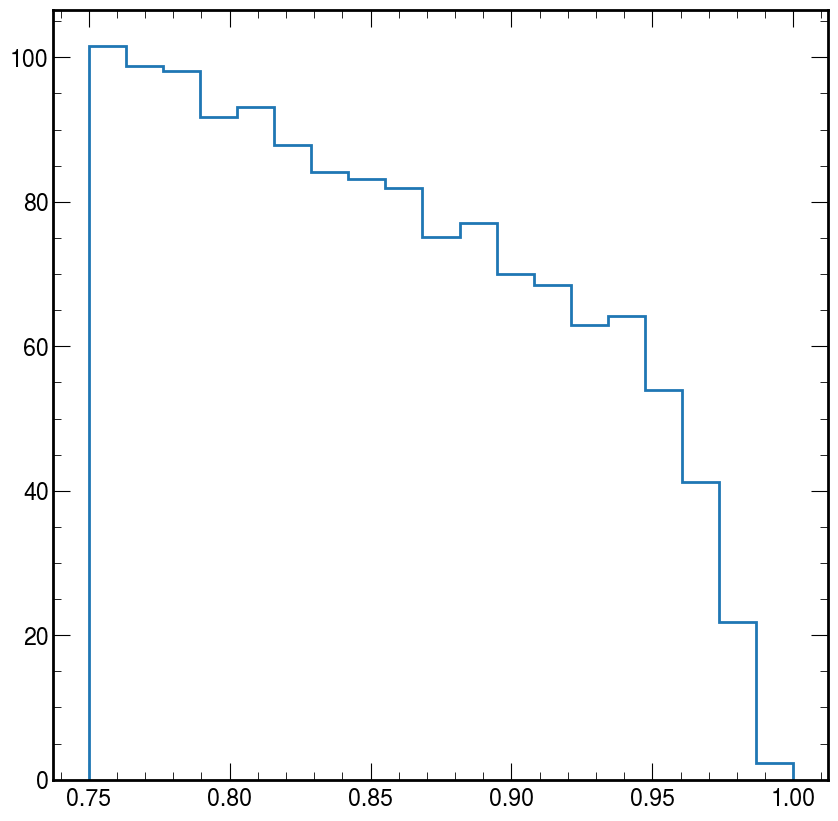

In [9]:
l = []
for year in years:
    for ch in channels:
        l.append(events_dict[year][ch]["TTbar"])

df = pd.concat(l)
msk = (df["THWW"]>0.75) & (df["n_bjets_T"]>0)

plt.hist(
    df["THWW"][msk],
    weights=df["nominal"][msk],
    bins=np.linspace(0.75,1,20),
    histtype="step",
    lw=2,
#     density=True,
    label="TTbar",
)

plt.hist(
    df["THWW"][msk],
    weights=df["nominal"][msk] * df["LP_weight"][msk],
    bins=np.linspace(0.75,1,20),
    histtype="step",
#     density=True,
    lw=2,
    label="TTbar (after LP reweighting)",
)

plt.legend();

In [ ]:
l = []
for year in years:
    for ch in channels:
        l.append(events_dict[year][ch]["TTbar"])

df = pd.concat(l)
msk = (df["THWW"]>0.75) & (df["n_bjets_T"]>0)

df = df[msk]


is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)                        
is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)


for sample in [
    "TTbar_is_top_lq",
    "TTbar_is_top_lqq",
    "TTbar_others",    
]:

    if sample == "TTbar_is_top_lq":
        df = df[is_top_lq]
    elif sample == "TTbar_is_top_lqq":
        df = df[is_top_lqq]
    else:
        df = df[~(is_top_lq | is_top_lqq)]
        
    plt.hist(
        df["THWW"],
        weights=df["nominal"] * df["LP_weight"],
        bins=np.linspace(0.75,1,20),
        histtype="step",
    #     density=True,
        lw=2,
        label=sample,
    )

    plt.legend();                        

INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \equiv from STIXGeneral


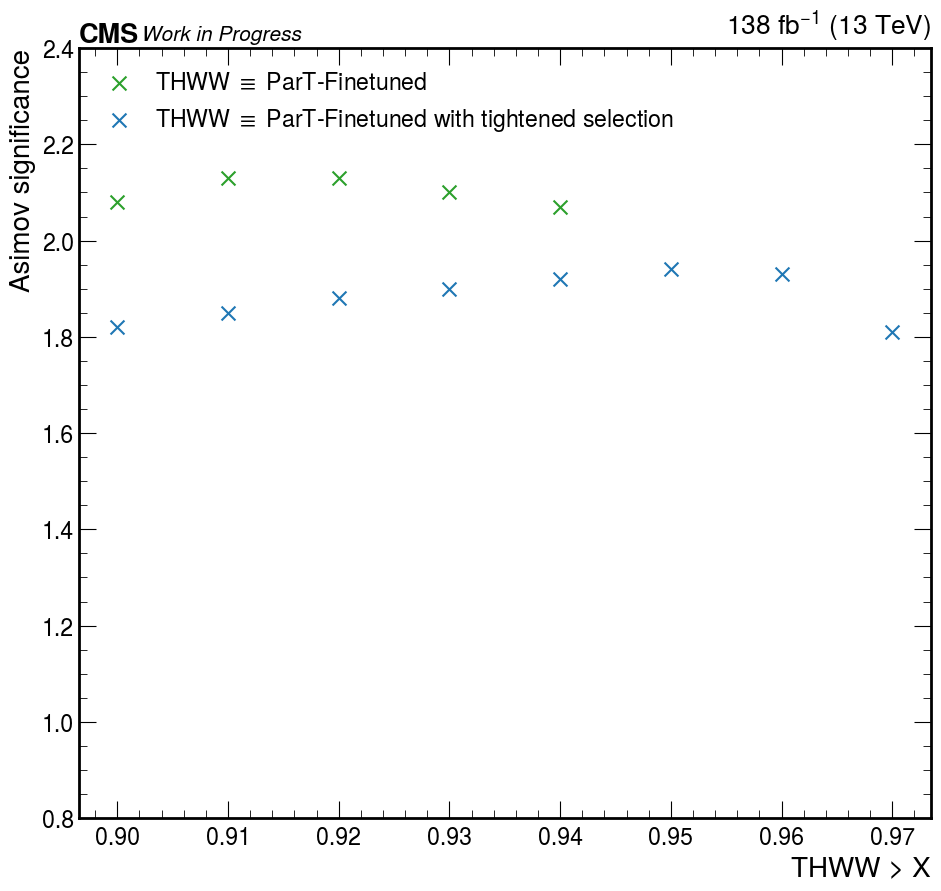

In [93]:
plt.rcParams.update({"font.size": 20})

THWW_cuts = [0.90, 0.91, 0.92, 0.93, 0.94]
THWW_cuts_tighten = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]

sig = [2.08, 2.13, 2.13, 2.10, 2.07]
sig_tighten = [1.82, 1.85, 1.88, 1.90, 1.92, 1.94, 1.93, 1.81]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))

ax.scatter(THWW_cuts, sig, marker="x", s=100, label=r"THWW $\equiv$ ParT-Finetuned", color="tab:green")
ax.scatter(THWW_cuts_tighten, sig_tighten, marker="x", s=100, label=r"THWW $\equiv$ ParT-Finetuned with tightened selection", color="tab:blue")

ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel("THWW > X")

# x1 = 0.897
# x2 = 0.932
y1 = 0.8
y2 = 2.4

# ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/finetuned_tighten_selection.pdf")

In [131]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        if use_Fake:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other & \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        if use_Fake:        
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })

        if use_Fake:           
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
#             texdata += f" & {(sig_dict[sample]):.2f}"
            
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
#             texdata += f" & {(bkg_dict[sample]):.2f}"            
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      

In [280]:
shift = 50
WP_VBF = 0.905
WP2 = 0.93

presel = {
#     "Pre-selection": f"THWW>0", # dummy
    
#     "$\Delta R(\ell_{gen}, \ell_{reco}) > 0.001$": f"dR_genlep_recolep>0.001", # dummy
#     "$\Delta R(\ell_{gen}, \ell_{reco}) > 0.002$": f"dR_genlep_recolep>0.002", # dummy
#     "$\Delta R(\ell_{gen}, \ell_{reco}) > 0.005$": f"dR_genlep_recolep>0.005", # dummy    
#     "$\Delta R(\ell_{gen}, \ell_{reco}) > 0.01$": f"dR_genlep_recolep>0.01", # dummy
    
#     "Signal region": f"(THWW>0.92) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.75) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.905) & (THWW>0.75) & (n_bjets_T==0)",

    "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
    r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
    r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
    r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) )",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) )",      
    
    
#     "Top control region (RUN2)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2018)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2017)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2016)": f"(THWW>0.75) & (n_bjets_T>0)",
#     "Top control region (2016APV)": f"(THWW>0.75) & (n_bjets_T>0)",
    
#     "W+Jets control region (RUN2)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2018)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2017)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
#     "W+Jets control region (2016APV)": f"(THWW<0.90) & (THWW>0.75) & (n_bjets_T==0)",
    
    
#     r"VBF category (mjj$>$500 and deta$>$2.0)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( (mjj>500) & (deta>2.0) )",
#     r"ggF category (mjj$<$500 or deta$<$2.0)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( ( (mjj<500) | (deta<2.0) ) )",

#     r"VBF category (mjj$>$500 and deta$>$3.5)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( (mjj>500) & (deta>3.5) )",
#     r"ggF category (mjj$>$500 or deta$>$3.5)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( ( (mjj<500) | (deta<3.5) ) )",
    
#     r"VBF category (mjj$>$1000 and deta$>$3.5)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     r"ggF category (mjj$>$1000 or deta$>$3.5)": f"( (THWW>0.91) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) )",
    
#     "PF rel iso $>$ 0.00 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.00) )",
#     "PF rel iso $>$ 0.02 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.02) )",
#     "PF rel iso $>$ 0.06 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.06) )",
#     "PF rel iso $>$ 0.10 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.1) )",
#     "PF rel iso $>$ 0.12 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.12) )",
#     "PF rel iso $>$ 0.13 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.13) )",    
#     "PF rel iso $>$ 0.14 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.14) )",
#     "PF rel iso $>$ 0.145 (for low pT electrons)": "( (lep_pt<120) & (lep_isolation>0.145) )",
}

make_composition_table(events_dict, presel, add_soverb=True, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}
\begin{tabular}{c|ccccc|cccc|c}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{4}{c|}{Background yield} & \multicolumn{1}{c}{$s/\sqrt{b}$} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Fake & Other & \\

\hline
\hline
\multirow{2}{*}{VBF category} & \multicolumn{5}{c|}{9} & \multicolumn{4}{c|}{36} & \multicolumn{1}{c}{\multirow{2}{*}{2.015}} \\
 & 81\% & 17\% & 1\% & 0\% & 1\% & 49\% & 37\% & 0\% & 17\% &  \\

\hline
\multirow{2}{*}{ggF category $p_T \in $ [250, 350]} & \multicolumn{5}{c|}{6} & \multicolumn{4}{c|}{98} & \multicolumn{1}{c}{\multirow{2}{*}{0.647}} \\
 & 21\% & 64\% & 8\% & 5\% & 2\% & 35\% & 49\% & 1\% & 15\% &  \\

\hline
\multirow{2}{*}{ggF category $p_T \in $ [350, 500]} & \multicolumn{5}{c|}

In [281]:
# this one skips the Fake altogether (relevant to signal region)

def make_composition_table(ev, presel, add_soverb=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    
    bkg = ["TTbar", "WJetsLNu", "Others"]
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|ccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|ccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{3}{c}{Background yield} \\\\\n")
        print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    years_to_cover = years
    for region, sel in presel.items():
        if "2018" in region:
            years_to_cover = ["2018"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2017" in region:
            years_to_cover = ["2017"]
        elif "2016APV" in region:
            years_to_cover = ["2016APV"]
        elif "2016" in region:
            years_to_cover = ["2016"]
        else:
            years_to_cover = years
        
        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })
    
        bkg_dict = OrderedDict({
            "TTbar": 0,
            "WJetsLNu": 0, 
            "Others": 0,    
        })  

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years_to_cover:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["nominal"].sum()                    
                        sig_dict[sample] += df["nominal"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["nominal"].sum()
                        bkg_dict[sample] += df["nominal"].sum()
                    else:
                        tot_bkg += df["nominal"].sum()                        
                        bkg_dict["Others"] += df["nominal"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["nominal"].sum()
                    else:
                        b += df["nominal"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{3}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{3}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:}")
    print("\\end{center}")
    print("\\end{table}")      
    
shift = 50
WP_VBF = 0.905
WP2 = 0.93

presel = {
    "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
    
    r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
    r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
    r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
}

make_composition_table(events_dict, presel, add_soverb=True)    

# Stacked hists

In [286]:
with open("trg_eff_SF.pkl", "rb") as f:
    TRIGGER_SF = pickle.load(f)

In [287]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)
                
def compute_met_phi(jet_phi, delta_phi):
    # Calculate MET Phi
    met_phi = jet_phi - delta_phi
    
    # Ensure MET Phi is within the range [-pi, pi]
    met_phi = np.arctan2(np.sin(met_phi), np.cos(met_phi))
    
    return met_phi                

In [291]:
from syst_unc_utils import (
    fill_syst_unc_hists,
    get_total_syst_unc,
    initialize_syst_unc_hists,
)

vars_to_plot = [
    
#     "dR_genlep_recolep", 
        ############# AN start
#         "FirstFatjet_pt",
#         "fj_lsf3",
#         "fj_mass",
#         "fj_ParT_mass",
#         "fj_pt",
#         "ht",
#         "lep_fj_dr",  
#         "lep_isolation_ele_highpt",
#         "lep_isolation_ele_lowpt",
#         "lep_isolation_mu_highpt",
#         "lep_isolation_mu_lowpt",
#         "lep_met_mt",
#         "lep_misolation_ele_highpt",
#         "lep_misolation_ele_lowpt",
#         "lep_misolation_mu_highpt",
#         "lep_misolation_mu_lowpt",
#         "lep_pt",
#         "lep_eta",
#         "met_fj_dphi",
#         "met_pt",
#         "NumFatjets",
#         "NumOtherJets",
#         "rec_higgs_m",
#         "rec_W_lnu_m",
#         "rec_W_qq_m",
#         "SecondFatjet_pt",
#         "THWW",
#         "met_phi",
        ############## AN end

        ############## Fake vs QCD
        "fj_pt",
        "lep_pt",
        "lep_eta",
        "met_pt",
        "lep_fj_dr",
        "THWW",
    
        ############## Control regions
#         "fj_pt",
#         "lep_pt",
#         "lep_fj_dr",
#         "met_pt",
#         "rec_higgs_m",

        ############## Fake validation region
#         "fj_pt",
#         "lep_pt",
#         "lep_eta",
#         "met_pt",
    
        # more
#         "fj_lsf3",
#         "rec_higgs_m",
#         "fj_mass",
    #     "fj_ParT_mass",
#         "fj_pt",
    #     "lep_fj_dr",
    #     "met_pt",
    #     "rec_W_lnu_m",
    #     "rec_W_qq_m",
    #     "met_phi",
#         "rec_higgs_pt",
#         "lep_eta",
#     "rho",
#     "pt_ratio",
]

samples_to_plot = [
        "ggF",
        "VBF",
        "ttH",
        "WH",
        "ZH",
#         "Fake",
        "SingleTop",
        "DYJets",
        "WZQQ",    
        "Diboson",
        "EWKvjets",    
        "TTbar",
        "WJetsLNu",
        "Data",
    
    "QCD",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
]


years_to_plot = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

channels_to_plot = [
        "ele",
        "mu",
]

plot_syst_unc = True
massbin = 5

if plot_syst_unc:
    import sys

    sys.path.append("../combine/")
    from systematics import get_systematic_dict

    SYST_DICT = get_systematic_dict(years_to_plot)
    
    SYST_UNC_up, SYST_UNC_down = {}, {}
    SYST_hists = initialize_syst_unc_hists(SYST_DICT, {"years_to_plot": years_to_plot, "vars_to_plot": vars_to_plot, "massbin": massbin})  

In [292]:
WP_ggF = 0.93
WP_VBF = 0.88

region_sel = {
    "Pre-selection": "met_pt>20",   # dummy
#     "Pre-selection": "THWW>0.75",   # dummy

#     "Fake validation": "fj_mass>30 & fj_mass<40",
#     "Analysis": "fj_mass>40",
    
#     "Pre-selection": "rho>-5",   # dummy    
#     "Pre-selection": "rho>-5 & fj_mass>40 & fj_mass>10",   # dummy    
    
#     "Pre-selection": "fj_mass>20 & fj_mass<40",   # dummy

#     "SR": f"THWW>{WP_VBF} & (n_bjets_T==0)",
#     "Top CR": f"(n_bjets_T>0) & THWW>0.9",
#     "WJets CR": f"(THWW<{WP_VBF}) & (n_bjets_T==0)",
}
region, sel = list(region_sel.items())[0]

shift = 50
categories_sel = {
#     "VBF category": f"( (THWW>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     "ggF category": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) ) & (VH_fj_VScore<0.9)",    
    
#     r"ggF category $p_T \in $ " + f"[{200+shift}, {300+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt<{300+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{300+shift}, {450+shift}]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) ) & (VH_fj_VScore<0.9)",
#     r"ggF category $p_T \in $ " + f"[{450+shift}, Inf]": f"( (THWW>{WP_ggF}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (rec_higgs_pt>{450+shift}) ) & (VH_fj_VScore<0.9)",      
}

num, den = 0, 0
threshold = 0

# fill histograms
import utils
from utils import get_axis

# instantiate nominal histograms
hists = {}
for var_to_plot in vars_to_plot:
    
    hists[var_to_plot] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.get_axis(var_to_plot,massbin),
        storage=hist2.storage.Weight(),
    )

# start filling the histograms
for var_to_plot in vars_to_plot:    
    for year in years_to_plot:
        for ch in channels_to_plot:
            for sample in samples_to_plot:   

                # -------------- some samples may be split during plotting to matched/unmatched
                if "TTbar" in sample:
                    
                    if "TTbar_LP" in sample:
                        df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")
                        df["nominal"] = df["LP_weight_nom"]
                    else:
                        df = pd.read_parquet(f"../LP/LP_TTbar_{year}_{ch}.parquet")           
                    
                    # TODO
                    df = events_dict[year][ch]["TTbar"]


                    ########## seperate topologies by color                    
                    is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)                        
                    is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

                    if (sample == "TTbar_is_top_lq") or (sample == "TTbar_LP_is_top_lq"):
                        df = df[is_top_lq]
                    elif (sample == "TTbar_is_top_lqq") or (sample == "TTbar_LP_is_top_lqq"):
                        df = df[is_top_lqq]
                    elif (sample == "TTbar_others") or (sample == "TTbar_LP_others"):
                        df = df[~(is_top_lq | is_top_lqq)]
                    elif sample == "TTbar_allmatched":
                        df = df[df["fj_isTop_W_lep_b"] == 1]
                    elif sample == "TTbar_unmatched":
                        df = df[df["fj_isTop_W_lep_b"] != 1]

                elif "WJetsLNu" in sample:
                    df = events_dict[year][ch]["WJetsLNu"]

                    if "WJetsLNu_unmatched" in sample:
                        print("WJetsLNu_unmatched")                        
                        df = df[df["fj_V_isMatched"] != 1]
                    elif "WJetsLNu_matched" in sample:
                        print("WJetsLNu_matched")                        
                        df = df[df["fj_V_isMatched"] == 1]

                else:
                    df = events_dict[year][ch][sample]
                
#                 df["rho"] = np.log(df["fj_mass"]**2 / df["fj_pt"]**2)

#                 df["pt_ratio"] = df["lep_pt"] / df["fj_pt"]
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "EWKvjets":
#                     threshold = 20
#                     den += len(df['nominal'])
#                     num += sum(df["nominal"]>threshold)

#                     df = df[df["nominal"] < threshold]
                
                # ----------- some variables need manual tweaking
                if var_to_plot == "met_phi":

                    def compute_met_phi(jet_phi, delta_phi):
                        met_phi = jet_phi - delta_phi
                        met_phi = np.arctan2(np.sin(met_phi), np.cos(met_phi))  # ensure it is between [-pi, pi]
                        return met_phi

                    df["met_phi"] = compute_met_phi(df["fj_phi"], df["met_fj_dphi"])

                elif "lep_isolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_isolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_isolation"]

                elif "lep_misolation_ele" in var_to_plot:
                    if ch != "ele":
                        continue
                    df = df[(df["lep_pt"] > 120)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 120)]
                    df[var_to_plot] = df["lep_misolation"]

                elif "lep_misolation_mu" in var_to_plot:
                    if ch != "mu":
                        continue
                    df = df[(df["lep_pt"] > 55)] if "highpt" in var_to_plot else df[(df["lep_pt"] < 55)]
                    df[var_to_plot] = df["lep_misolation"]

                # ----------- done with the above.  
                
                add_TRG_SF = True
                if (add_TRG_SF) and (sample != "Data"):
                    ptbinning = [2000, 200, 120, 30]
                    etabinning = [-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]

                    for i in range(len(ptbinning)-1):
                        high_pt = ptbinning[i]
                        low_pt = ptbinning[i+1]

                        msk_pt = (df["lep_pt"] >= low_pt) & (df["lep_pt"] < high_pt)

                        for j in range(len(etabinning)-1):
                            low_eta = etabinning[j]
                            high_eta = etabinning[j+1]

                            msk_eta = (abs(df["lep_eta"]) >= low_eta) & (abs(df["lep_eta"]) < high_eta)

                            df["nominal"][msk_pt & msk_eta] *= TRIGGER_SF["UL" + year[2:].replace("APV", "")]["nominal"][i,j]
                        
#                 if "bjets" in region:  # if there's a bjet selection, add btag SF to the nominal weight
#                     if (sample != "Data") and (sample != "Fake"):
#                         df["nominal"] *= df["weight_btag"]
            
#                 if "TTbar" in sample:
#                     df["nominal"] *= df["LP_weight"]
                    
#                 if sample == "Fake":
#                     df["nominal"] *= 0.75

                hists[var_to_plot].fill(
                    samples=sample,
                    var=df[var_to_plot],
                    weight=df["nominal"],
                )

                if plot_syst_unc:
                    SYST_hists_sig = fill_syst_unc_hists(SYST_DICT, SYST_hists, year, ch, sample, var_to_plot, df)

#     try:
#         print(f"Removing {num} out of {den} EWKvjets events by applying nominal<{threshold} ({(100*num/den):.2f}%)")
#     except:
#         z=1

    fix_neg_yields(hists[var_to_plot])
    if plot_syst_unc:
        SYST_UNC_up[var_to_plot], SYST_UNC_down[var_to_plot] = get_total_syst_unc(
            SYST_hists[var_to_plot]
        )
        
        sys_keys = ["sys", "prongs", "unclust", "distortion"]
        for sys_key in sys_keys:
            up = SYST_hists_sig[var_to_plot]["up"][f"LP_weight_{sys_key}"].values()
            down = SYST_hists_sig[var_to_plot]["down"][f"LP_weight_{sys_key}"].values()

            SYST_hists[var_to_plot]["up"][f"LP_weight_{sys_key}"].view().value = np.maximum(up, down)
            SYST_hists[var_to_plot]["down"][f"LP_weight_{sys_key}"].view().value = np.minimum(up, down)

Will plot fj_pt histogram
#bins: 30, chi_square: 141.832, reduced_chi_square: 4.891
Will plot lep_pt histogram
#bins: 40, chi_square: 188.349, reduced_chi_square: 4.829
Will plot lep_eta histogram
#bins: 35, chi_square: 285.341, reduced_chi_square: 8.392
Will plot met_pt histogram
#bins: 40, chi_square: 142.410, reduced_chi_square: 3.652
Will plot lep_fj_dr histogram
#bins: 35, chi_square: 191.874, reduced_chi_square: 5.643
Will plot THWW histogram
#bins: 25, chi_square: 50.332, reduced_chi_square: 2.097



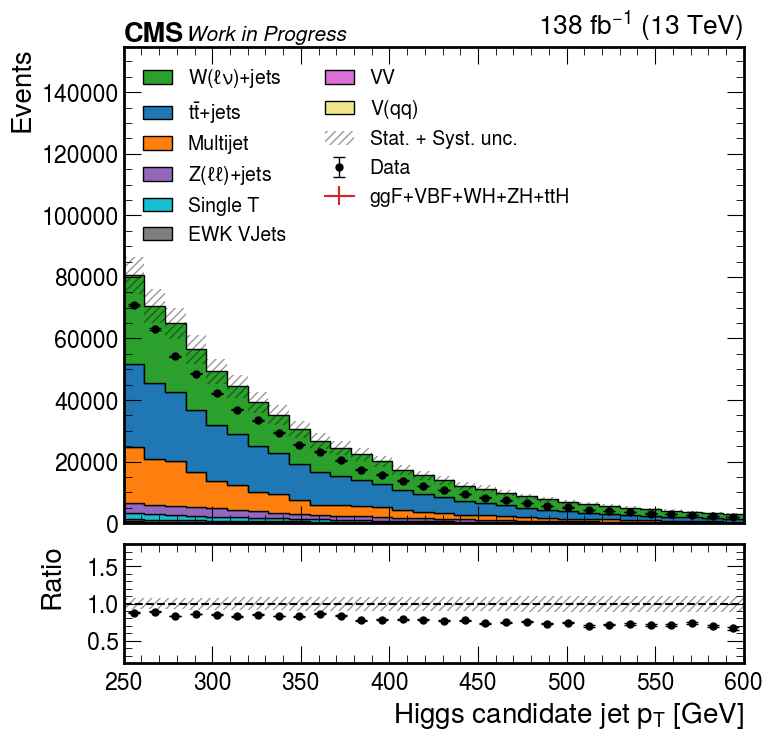

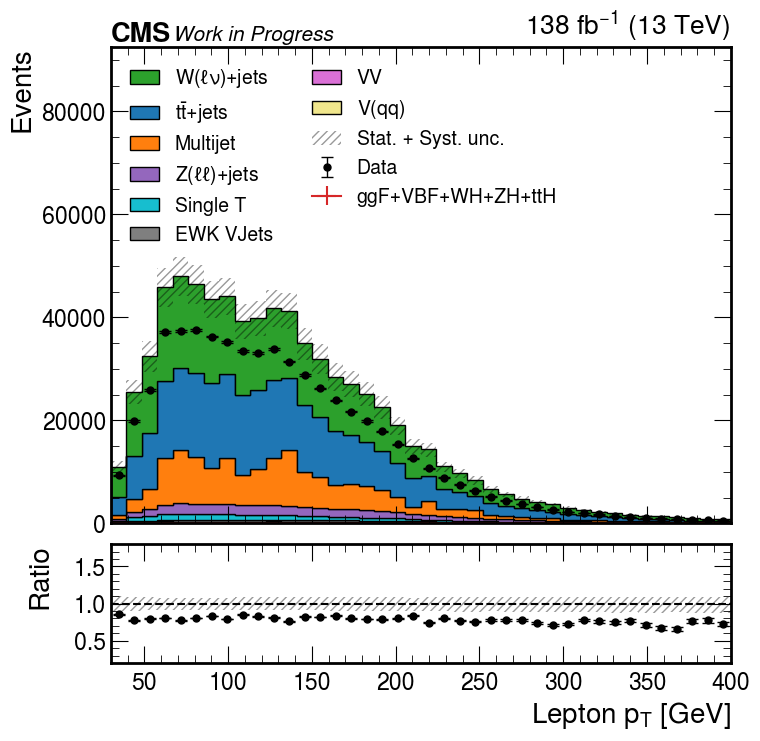

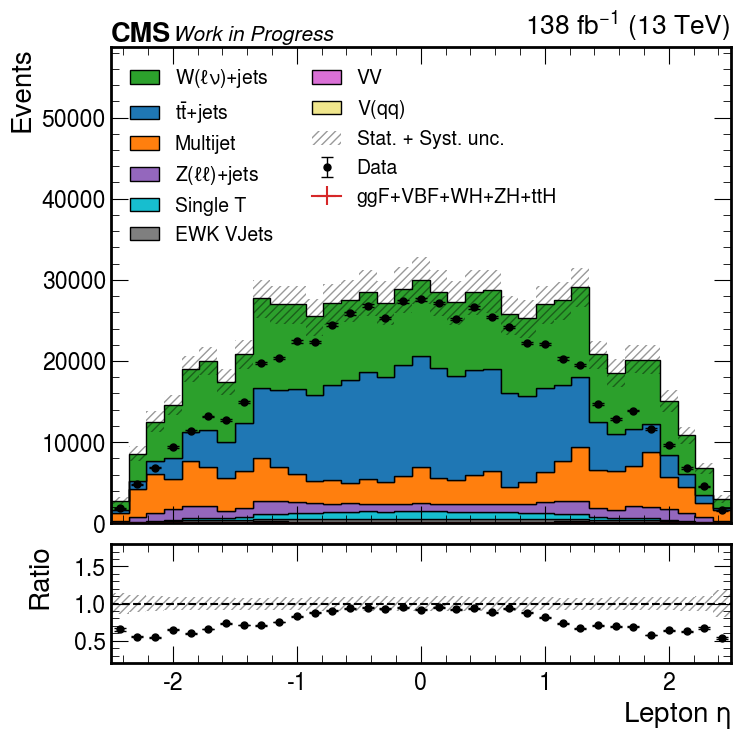

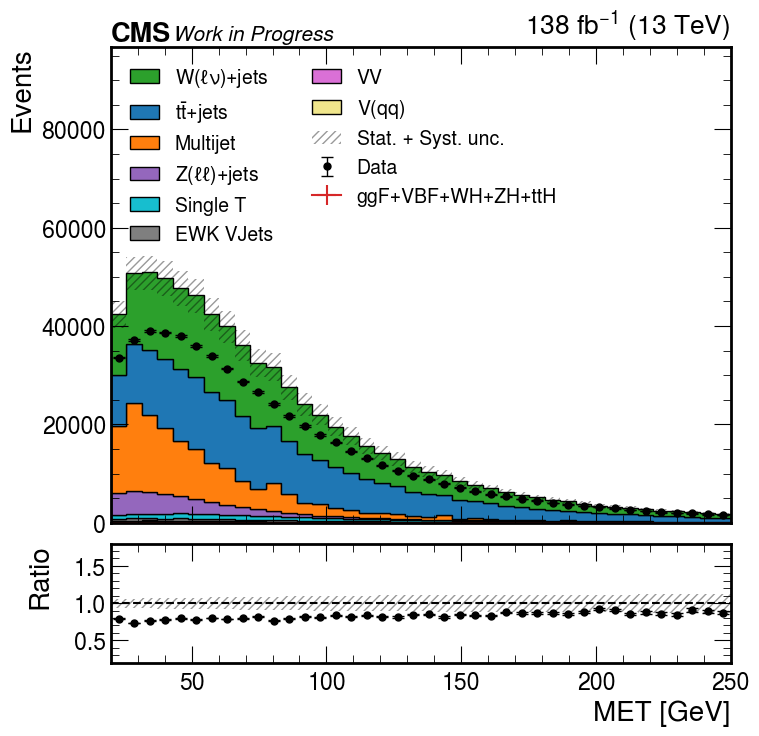

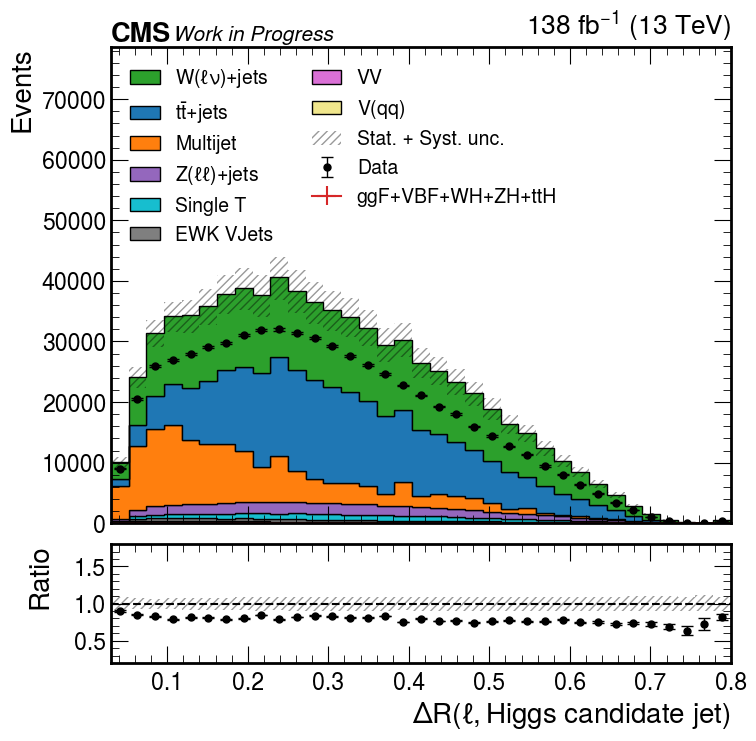

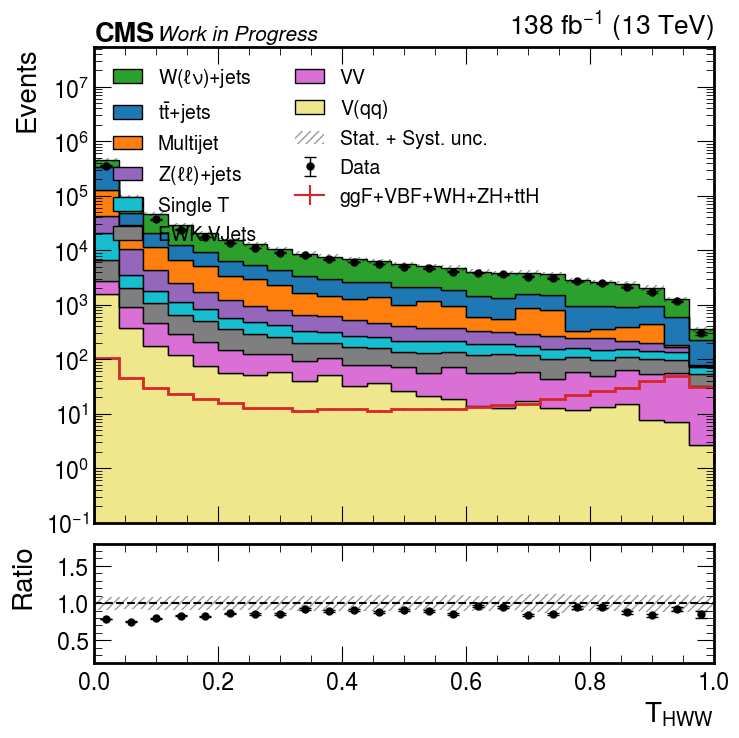

In [294]:
plt.rcParams.update({"font.size": 20})
add_data = False

if "SR" in region or ("Signal region") in region:
    blind_region=[90,160]
    mult = 10
else:
    blind_region=False
    mult = 1

if "VBF category" in categories_sel:
    mult = 5


from utils import plot_hists as plot_hists
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/UL16/without_trigSF"
PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol"

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/{year}/"
# if len(years_to_plot) == 4:
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/Run2/"

# if add_TRG_SF:
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/eletriggerSF/UL{year[2:].replace('APV', '')}/with_trgSF"
# else:
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/eletriggerSF/UL{year[2:].replace('APV', '')}/without_trgSF"

if not os.path.exists(PATH):
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

plot_hists(hists, years_to_plot, channels_to_plot, vars_to_plot,
            add_data=True,
            logy=False,
            mult=mult,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
#             text_=f"Before LP reweighting",
#             text_=f"ggF category",
#             text_=list(categories_sel)[0],
            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}",
#            save_as=f"{ch}",
#             plot_Fake_unc=0.25,
            plot_syst_unc=(SYST_UNC_up, SYST_UNC_down) if plot_syst_unc else None,
           add_soverb=False,
           legend_ncol=2,
#            seperate_Fake_unc=True,
          )
print()

# if "QCD" in samples_to_plot:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1)
# else:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1, usefake=True)    

# STXS binning
https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/tutorial2023_unfolding/unfolding_exercise/#simplified-unfolding


Trace: 0.438


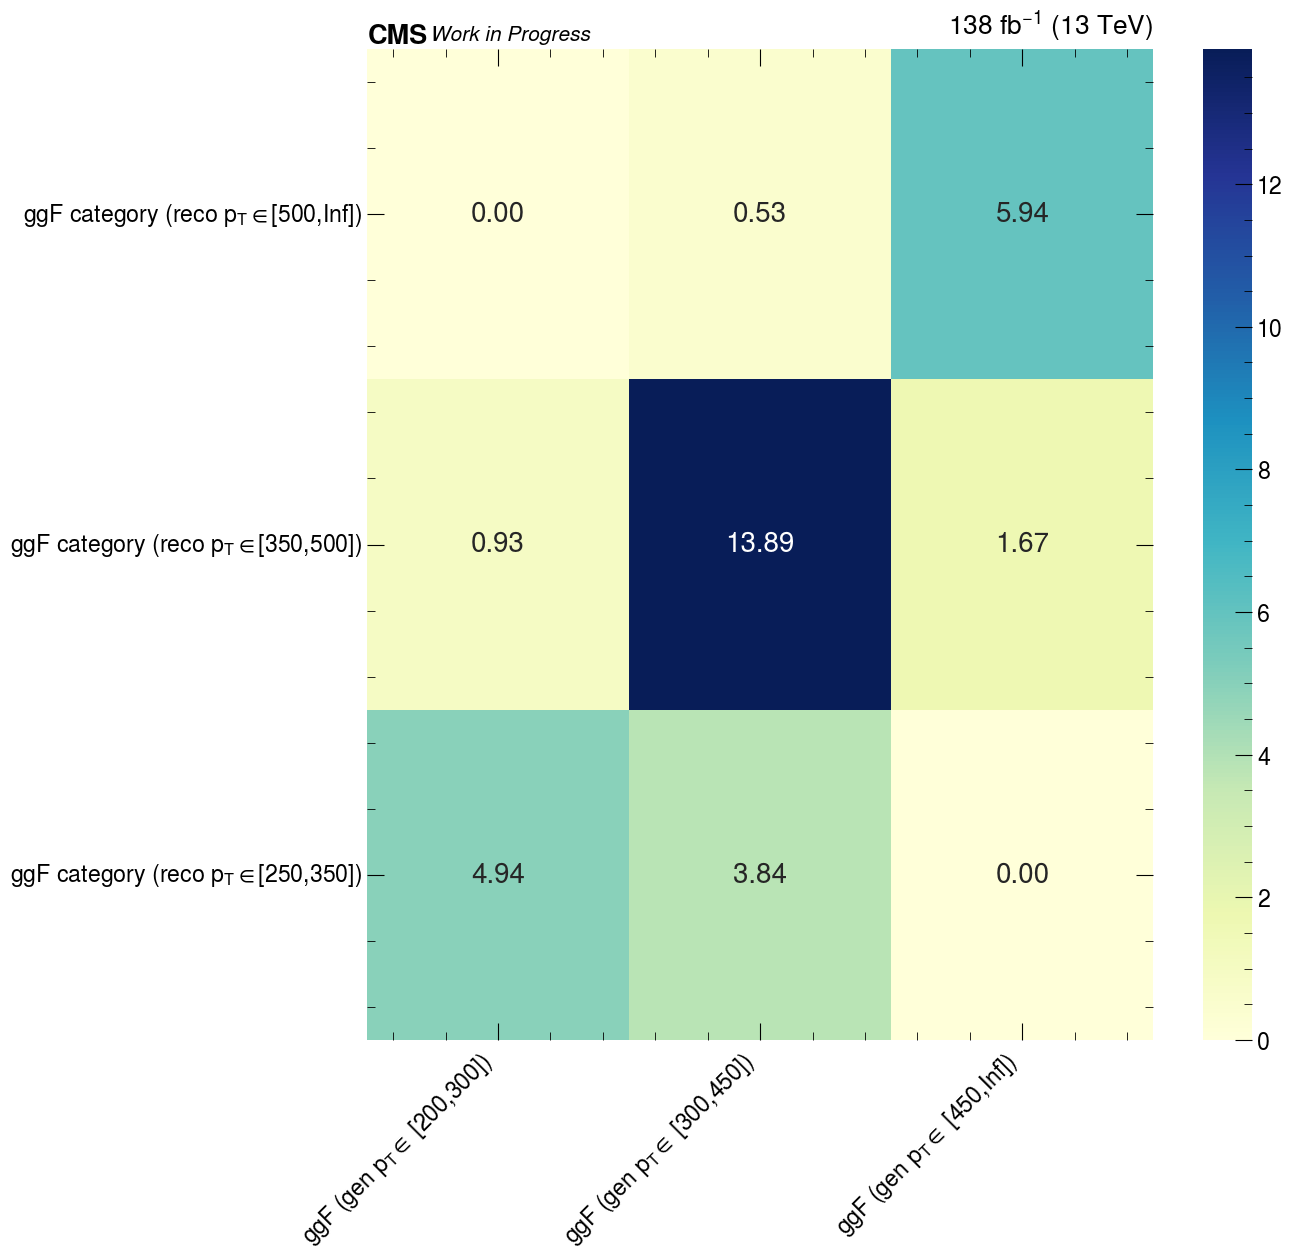

In [27]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import seaborn as sns

lab_dict = {
    "rec_higgs_pt": r"Higgs reconstructed $p_T$ [GeV]",
    "fj_genH_pt": r"Gen Higgs $p_T$ [GeV]",
    
}

years = [
    "2018",
    "2017",
    "2016APV",
    "2016",
]
samples = [
    "ggF",
#     "VBF",
#     "ttH",
#     "ZH",
#     "WH",
]   

stxs_bins = {
    r'ggF (gen $p_T \in$ [200,300])': 
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (fj_genH_pt>200) & (fj_genH_pt<300) )",
    
    r'ggF (gen $p_T \in$ [300,450])': 
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (fj_genH_pt>300) & (fj_genH_pt<450) )",
    
    r'ggF (gen $p_T \in$ [450,Inf])': 
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (fj_genH_pt>450) )",
      
}

norm = False
shift = 50
reco_bins = {
#     r"ggF category (reco $p_T \in$" + f"[{450+shift},Inf])":
#         f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (rec_higgs_pt>{450+shift}) )",
    
#     r"ggF category (reco $p_T \in$" + f"[{300+shift},{450+shift}])":
#         f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) )",
    
    r"ggF category (reco $p_T \in$" + f"[{500},Inf])":
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (rec_higgs_pt>{450+shift}) )",
    
    r"ggF category (reco $p_T \in$" + f"[{300+shift},{500}])":
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (rec_higgs_pt>{300+shift}) & (rec_higgs_pt<{450+shift}) )",    
    
    r"ggF category (reco $p_T \in$" + f"[250,{300+shift}])":
        f"( (n_bjets_T==0) & (THWW>0.93) ) & ( (mjj<1000) | (deta<3.5) ) & ( (rec_higgs_pt>250) & (rec_higgs_pt<{300+shift}) )",
}

M = np.zeros((len(stxs_bins),len(reco_bins)))
Tot = np.zeros((len(stxs_bins),len(reco_bins)))

for year in years:
    for ch in channels:
        for sample in samples:        
            df = events_dict[year][ch][sample]

            for i, (stxs_bin, gen_sel) in enumerate(stxs_bins.items()):    
                df1 = df.query(gen_sel)

                for j, (reco_bin, reco_sel) in enumerate(reco_bins.items()):
                    df2 = df1.query(reco_sel)
                    M[j, i] += df2["nominal"].sum()

if norm:
    # normalize the matrix across reco axis (columns)
    M = M / M.sum(axis=0)

# # normalize the matrix across reco axis (rows)
# M = M / M.sum(axis=1)

# Define the bin labels
gen_labels = list(stxs_bins)
reco_labels = list(reco_bins)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 13))
# sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels, cbar_kws={'label': 'Probability'})
sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels)

# ax.set_title(f"{sample}", pad=30)
# ax.set_title("WH+ZH+ttH", pad=30)

plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=45)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.tight_layout()    

if not norm:
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS_migration_matrix_shift{shift}_unnormalized.pdf")
else:
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS_migration_matrix_shift{shift}.pdf")

print(f"Trace: {np.trace(M / M.sum()):.3f}")

In [ ]:
# get lumi
import pickle as pkl
with open("../combine/templates/v8/hists_templates_Run2.pkl", "rb") as f:
    h = pkl.load(f)

In [ ]:
lab_dict = {
    "rec_higgs_pt": r"Higgs reconstructed $p_T$ [GeV]",
    "fj_genH_pt": r"Gen Higgs $p_T$ [GeV]",
    
}

stxs_bins = ["ggFpt200to300", "ggFpt300to450", "ggFpt450toInf", 
#              "VBF",
            ]
reco_bins = ['ggFpt250to350', "ggFpt350to500", "ggFpt500toInf", 
#              "VBF",
            ]
reco_bins.reverse()

M = np.zeros((len(stxs_bins),len(reco_bins)))

for i, stxs_bin in enumerate(stxs_bins):    
    for j, reco_bin in enumerate(reco_bins):
        M[j, i] = h[{"Systematic": "nominal", "Sample": stxs_bin, "Region": reco_bin}].sum().value

# normalize the matrix across reco axis
M = M / M.sum(axis=0)

In [ ]:
# Define the bin labels
gen_labels = list(stxs_bins)
reco_labels = list(reco_bins)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 13))
# sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels, cbar_kws={'label': 'Probability'})
sns.heatmap(M, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=gen_labels, yticklabels=reco_labels)

ax.set_title(f"{sample}", pad=30)
# ax.set_title("WH+ZH+ttH", pad=30)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.tight_layout()    

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS_migration_matrix_shift{shift}_{sample}.pdf")

# 2d-correlation mass plots

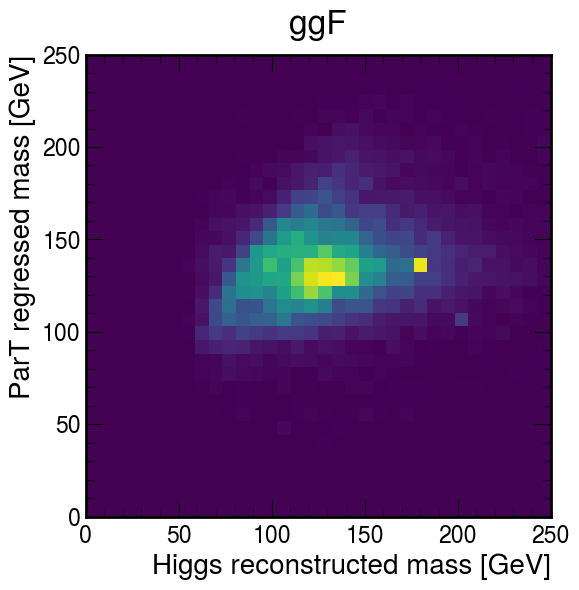

In [424]:
presel = {
    "Pre-selection": f"({tagger}>0.5) & fj_mass>55 & fj_lsf3>0.8",   # dummy

#     "bveto": f"n_bjets_T>0",   # dummy    

    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0) & fj_mass>55",

    
#     "Top CR": f"({tagger}>0) & (n_bjets_T>0) & fj_ParT_mass>100",
#     "Top CR": f"({tagger}>0.5) & (met_pt>50)",    
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0) & fj_ParT_mass>100",
}

lab_dict = {
    "rec_higgs_m": r"Higgs reconstructed mass [GeV]",
    "fj_ParT_mass": r"ParT regressed mass [GeV]",
    "fj_mass": r"Higgs candidate soft-drop mass [GeV]",
}


varx = "rec_higgs_m"
vary = "fj_ParT_mass"

for sample in [
    "ggF", 
#     "VBF",
#     "WJetsLNu",
#     "TTbar",
]:

    Xs, Ys, ws = [], [], []
    for year in years:
        for ch in channels:
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)
            
            Xs += list(df[varx])
            Ys += list(df[vary])

            ws += list(df["nominal"])


    fig, ax = plt.subplots(figsize=(6,6))

    plt.hist2d(
        Xs, 
        Ys,
        bins=np.linspace(0,250,35),
        weights=ws,
    )

    ax.set_title(sample, pad=15)
    ax.set_xlabel(lab_dict[varx])
    ax.set_ylabel(lab_dict[vary]);        

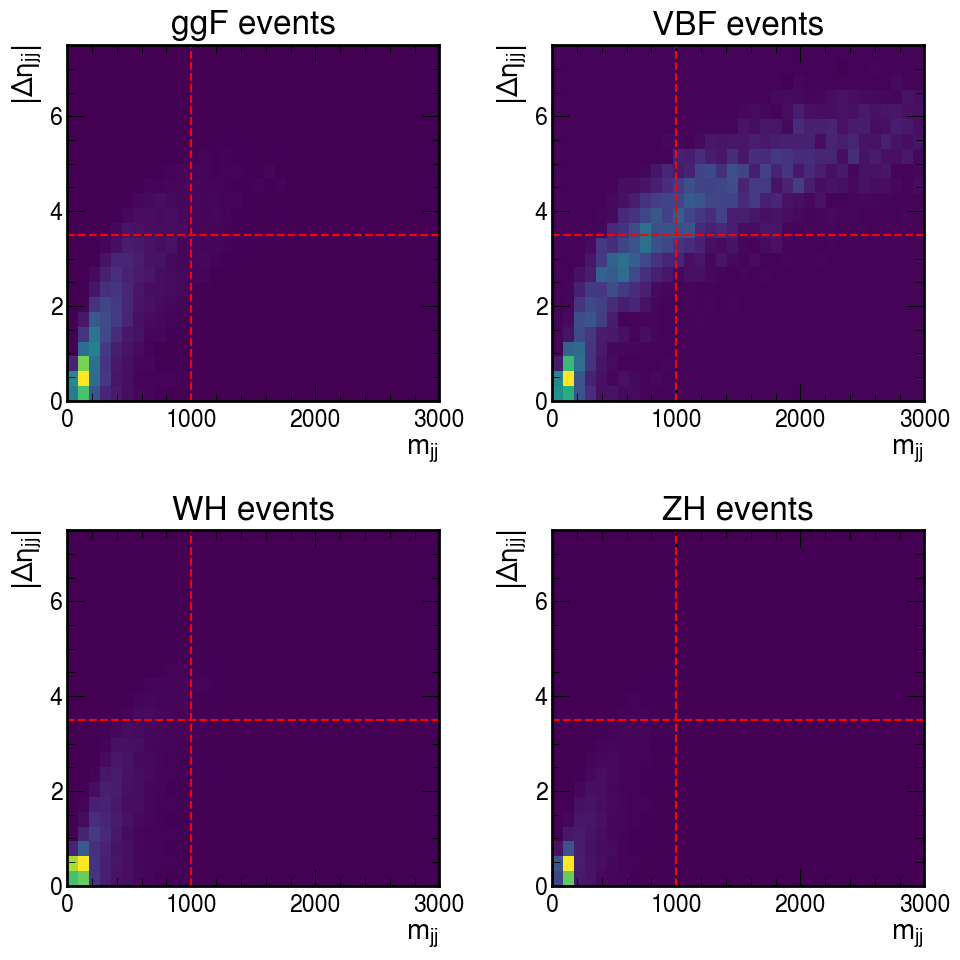

In [27]:
presel = {
    "Pre-selection": f"(THWW>0.75)",   # dummy

#     "bveto": f"n_bjets_T>0",   # dummy    

    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0) & fj_mass>55",

    
#     "Top CR": f"({tagger}>0) & (n_bjets_T>0) & fj_ParT_mass>100",
#     "Top CR": f"({tagger}>0.5) & (met_pt>50)",    
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0) & fj_ParT_mass>100",
}

lab_dict = {
    "rec_higgs_m": r"Higgs reconstructed mass [GeV]",
    "fj_ParT_mass": r"ParT regressed mass [GeV]",
    "fj_mass": r"Higgs candidate soft-drop mass [GeV]",
}


varx = "mjj"
vary = "deta"
# vary = "fj_ParT_mass"

fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

for sample, axi in {
    "ggF": (0,0),
    "VBF": (0,1),
    "WH": (1,0),
    "ZH": (1,1),
}.items():

    Xs, Ys, ws = [], [], []
    for year in years:
        for ch in channels:
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)
            
            Xs += list(df[varx])
            Ys += list(df[vary])

            ws += list(df["nominal"])

    axes[axi[0],axi[1]].hist2d(
        Xs, 
        Ys,
        bins=[np.linspace(0,3000,35), np.linspace(0,7.5,25)],
        weights=ws,
    )

    axes[axi[0],axi[1]].set_title(sample + " events", pad=8)
    
    axes[axi[0],axi[1]].axvline(1000, linestyle="--", c="red")
    axes[axi[0],axi[1]].axhline(3.5, linestyle="--", c="red")

    axes[axi[0],axi[1]].set_xlabel(r"$m_{jj}$")
    axes[axi[0],axi[1]].set_ylabel(r"$\left| \Delta \eta_{jj} \right|$")

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/lol/2d_1.pdf")

# Mass sculpting

In [243]:
presel = {
    "Pre-selection": f"(fj_mass>40)",   # dummy    
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]

# var = "rec_higgs_m"
# var = "fj_ParT_mass"
var = "fj_mass"

hists = {}
for sample in samples:

    if var == "rec_higgs_m":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(45, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_ParT_mass":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
        
    elif var == "fj_mass":
        hists[sample] = hist2.Hist(
            hist2.axis.StrCategory([], name="THWW", growth=True),
            hist2.axis.Variable(list(range(40, 255, massbin)), name="var", label=r"Higgs candidate soft-drop mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    else:
        continue
        
    for year in years:
        for ch in channels:
            if ch=="mu":
                if sample=="Fake":
                    continue
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)

            if "TTbar" in sample:
                df["nominal"] *= df["top_reweighting"]

            for cut in [0, 0.2, 0.5, 0.7, 0.9]:
                msk = df["THWW"]>cut

                x = df[var][msk]
                w = df["nominal
                       "][msk]

                hists[sample].fill(
                    THWW=f"THWW>{cut}",
                    var=x,
                    weight=w,
                )

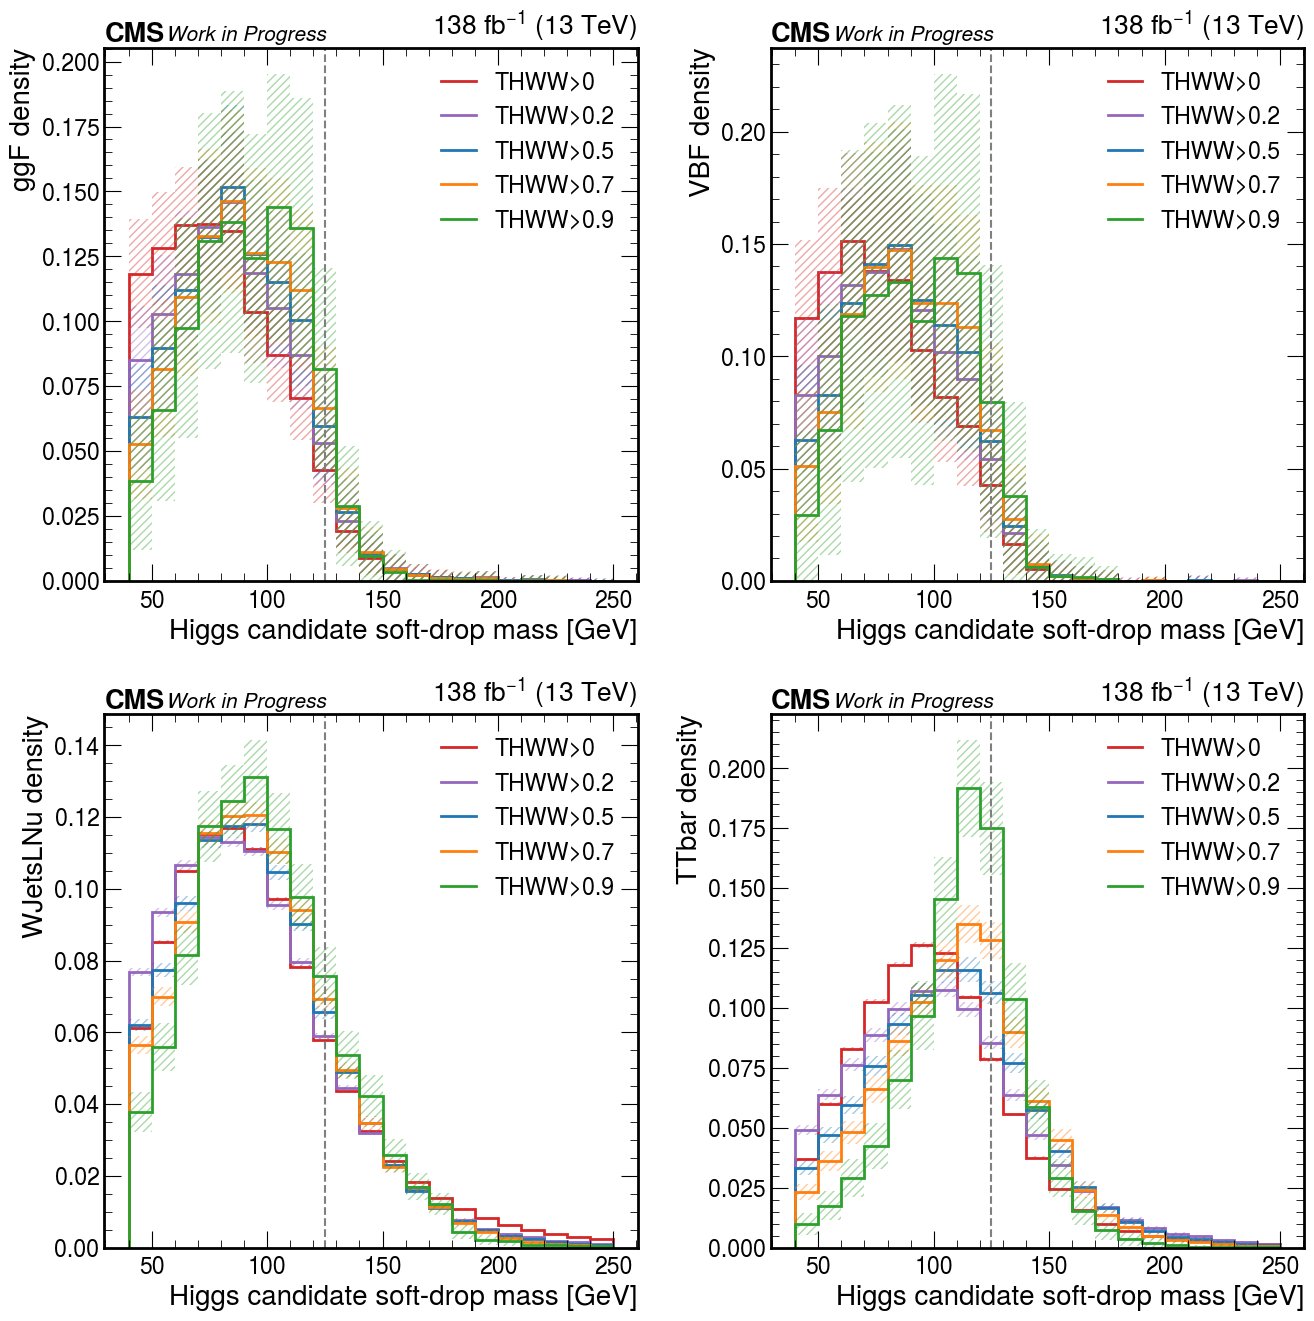

In [244]:
color_region = {
    "THWW>0": "tab:red",
    "THWW>0.2": "tab:purple",
    "THWW>0.5": "tab:brown",    
    "THWW>0.5": "tab:blue",
    "THWW>0.7": "tab:orange",
    "THWW>0.9": "tab:green",
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

for sample, axi in {
    "ggF": (0,0),
    "VBF": (0,1),
    "WJetsLNu": (1,0),
    "TTbar": (1,1),
}.items():
    
    h = hists[sample]

#     fig, ax = plt.subplots(figsize=(8, 8))
    for region in list(h.axes["THWW"]):

        bkg = h[{"THWW": region}].project("var")    

        bkg2 = bkg.values()/bkg.values().sum()
        hep.histplot(
    #         bkg,
            bkg2,
            bins=bkg.axes[0].edges,        
            ax=axes[axi[0],axi[1]],
    #         density=True,
            linewidth=2,
            label=region,
            flow="none",
            color=color_region[region]
        )

        axes[axi[0],axi[1]].stairs(
            values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
            baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
            edges=bkg.axes[0].edges,
            **errps(region),
    #         label="Stat. unc.",
        )

    axes[axi[0],axi[1]].legend()

    axes[axi[0],axi[1]].set_xlabel(bkg.axes.label[0])
    axes[axi[0],axi[1]].set_ylabel(f"{sample} density")

    axes[axi[0],axi[1]].set_ylim(0)
    # ax.set_yscale("log")
    
    axes[axi[0],axi[1]].axvline(125, color="grey", linestyle="--")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=axes[axi[0],axi[1]], fontsize=20)
    hep.cms.text("Work in Progress", ax=axes[axi[0],axi[1]], fontsize=15);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/masscultping_{var}.pdf")

# Mass distribution

In [276]:
samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]


regions = {
    "Pre-selection": f"(fj_mass>40)",   # dummy   
    "Signal region": f"(THWW>0.9)",   # dummy
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

var = "rec_higgs_m"
# var = "fj_ParT_mass"
# var = "fj_mass"
var = "rec_W_qq_m"
# var = "rec_W_lnu_m"

hists = {}
for region in regions:
    if var == "rec_higgs_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_ParT_mass":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "fj_mass":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(40, 255, massbin)), name="var", label=r"Higgs candidate soft-drop mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    elif var == "rec_W_qq_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(20, 0, 160, name="var", label=r"Reconstructed $W_{qq}$ mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )        
    elif var == "rec_W_lnu_m":
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(20, 0, 160, name="var", label=r"Reconstructed $W_{\ell \nu}$ mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),
        )
    else:
        continue    

    for sample in samples:

        for year in years:
            for ch in channels:
                if ch=="mu":
                    if sample=="Fake":
                        continue

                df = events_dict[year][ch][sample]

                if "TTbar" in sample:
                    df["nominal"] *= df["top_reweighting"]
                    
                df1 = df.query(regions[region])

                x = df1[var]
                w = df1["event_weight"]

                hists[region].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )

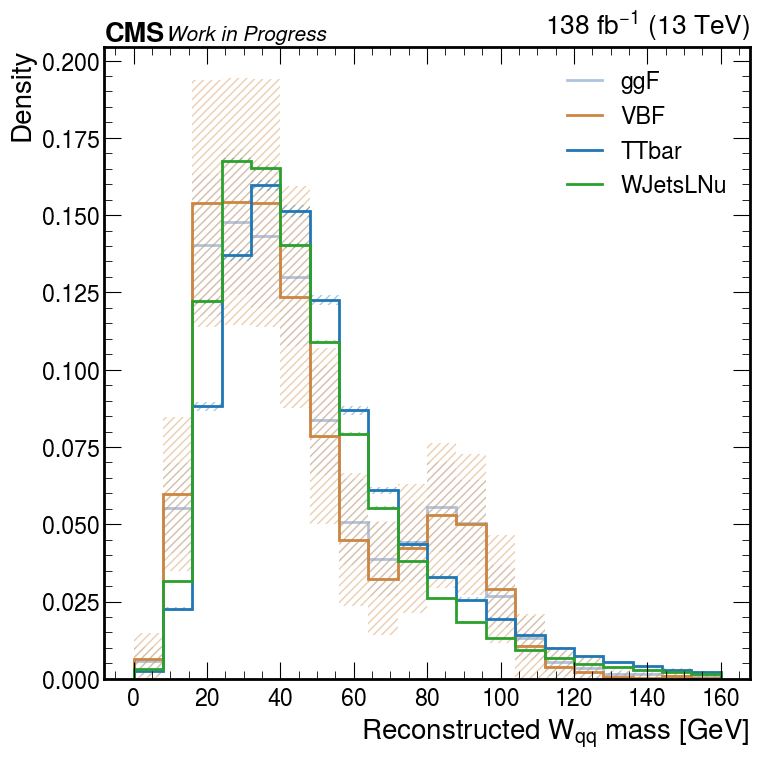

In [277]:
color_region = {
    "ggF": utils.color_by_sample["ggF"],
    "VBF": utils.color_by_sample["VBF"],
    "TTbar": utils.color_by_sample["TTbar"],
    "WJetsLNu": utils.color_by_sample["WJetsLNu"],
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, ax = plt.subplots(figsize=(8,8))

region = "Pre-selection"

h = hists[region]

#     fig, ax = plt.subplots(figsize=(8, 8))
for sample in list(h.axes["samples"]):

    bkg = h[{"samples": sample}].project("var")    

    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=2,
        label=sample,
        flow="none",
        color=color_region[sample]
    )

    ax.stairs(
        values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
        baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps(sample),
#         label="Stat. unc.",
    )

ax.legend()

ax.set_xlabel(bkg.axes.label[0])
ax.set_ylabel(f"Density")

ax.set_ylim(0)
# ax.set_yscale("log")

#     axes[axi].set_title(region, pad=35)

if var in ["rec_higgs_m", "fj_ParT_mass", "fj_mass"]:
    ax.axvline(125, color="grey", linestyle="--")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/mass_{var}_{region}.pdf")

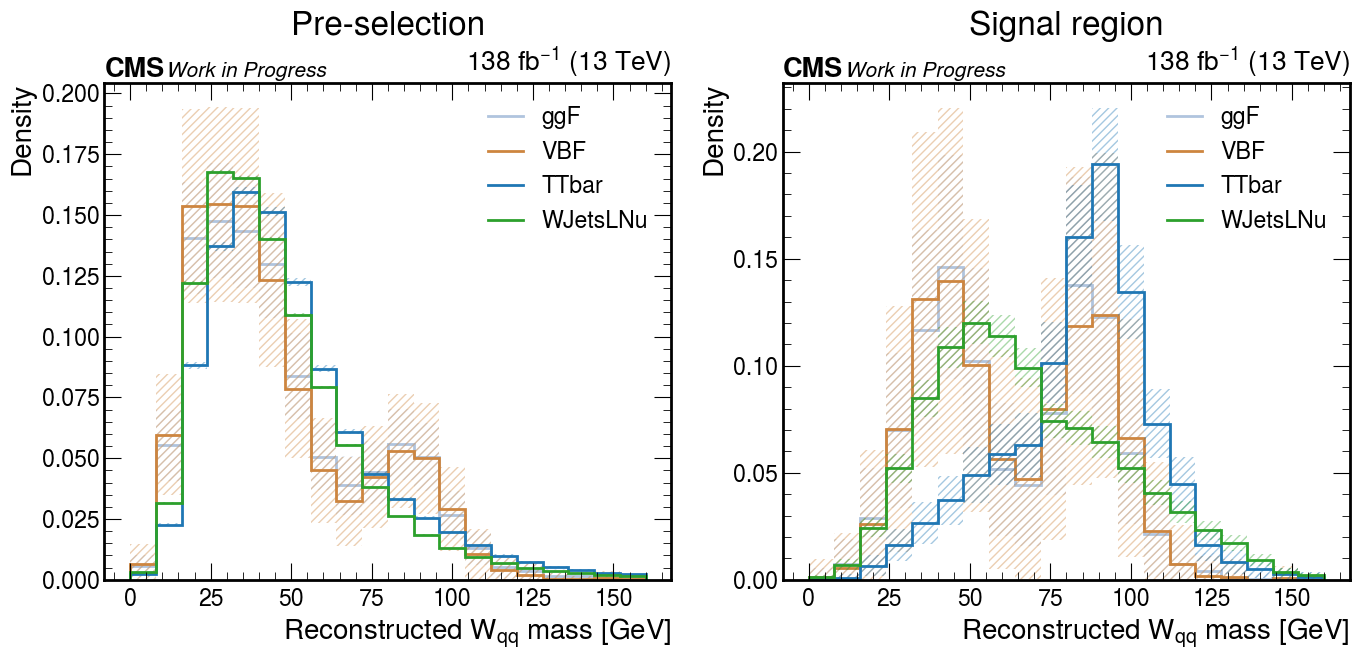

In [278]:
color_region = {
    "ggF": utils.color_by_sample["ggF"],
    "VBF": utils.color_by_sample["VBF"],
    "TTbar": utils.color_by_sample["TTbar"],
    "WJetsLNu": utils.color_by_sample["WJetsLNu"],
}

def errps(cut):
    return {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region[cut],
        "linewidth": 0,
        "alpha": 0.4,
    }


fig, axes = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for region, axi in {
    "Pre-selection": 0,
    "Signal region": 1,
}.items():
    
    h = hists[region]

#     fig, ax = plt.subplots(figsize=(8, 8))
    for sample in list(h.axes["samples"]):

        bkg = h[{"samples": sample}].project("var")    

        bkg2 = bkg.values()/bkg.values().sum()
        hep.histplot(
    #         bkg,
            bkg2,
            bins=bkg.axes[0].edges,        
            ax=axes[axi],
    #         density=True,
            linewidth=2,
            label=sample,
            flow="none",
            color=color_region[sample]
        )

        axes[axi].stairs(
            values=(bkg.values() + np.sqrt(bkg.values()))/bkg.values().sum(),
            baseline=(bkg.values() - np.sqrt(bkg.values()))/bkg.values().sum(),
            edges=bkg.axes[0].edges,
            **errps(sample),
    #         label="Stat. unc.",
        )

    axes[axi].legend()

    axes[axi].set_xlabel(bkg.axes.label[0])
    axes[axi].set_ylabel(f"Density")

    axes[axi].set_ylim(0)
    # ax.set_yscale("log")
    
    axes[axi].set_title(region, pad=35)
    
    if var in ["rec_higgs_m", "fj_ParT_mass", "fj_mass"]:
        axes[axi].axvline(125, color="grey", linestyle="--")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=axes[axi], fontsize=20)
    hep.cms.text("Work in Progress", ax=axes[axi], fontsize=15);
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.25)

    plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/mass_{var}_doubleplot.pdf")

In [ ]:
presel = {
    "Pre-selection": f"(THWW>0.5) & (fj_mass>40)",   # dummy    
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

import utils

massbin = 10

samples = [
    "ggF",
    "VBF",
    "TTbar",
    "WJetsLNu",
]

hists = {}
for sample in samples:

    hists[sample] = hist2.Hist(
        hist2.axis.StrCategory([], name="THWW", growth=True),
        hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"ParT mass [GeV]", overflow=True),
        storage=hist2.storage.Weight(),
    )      
        
        
    for year in years:
        for ch in channels:
            if ch=="mu":
                if sample=="Fake":
                    continue
            region, sel = list(presel.items())[0]

            df = events_dict[year][ch][sample]
            df = df.query(sel)

            if "TTbar" in sample:
                df["nominal"] *= df["top_reweighting"]

            for cut in [0.5, 0.7, 0.9]:
                msk = df["THWW"]>cut

                x = df[var][msk]
                w = df["nominal"][msk]

                hists[sample].fill(
                    THWW=f"THWW>{cut}",
                    var=x,
                    weight=w,
                )

In [163]:
var

'rec_higgs_m'

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["nominal"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


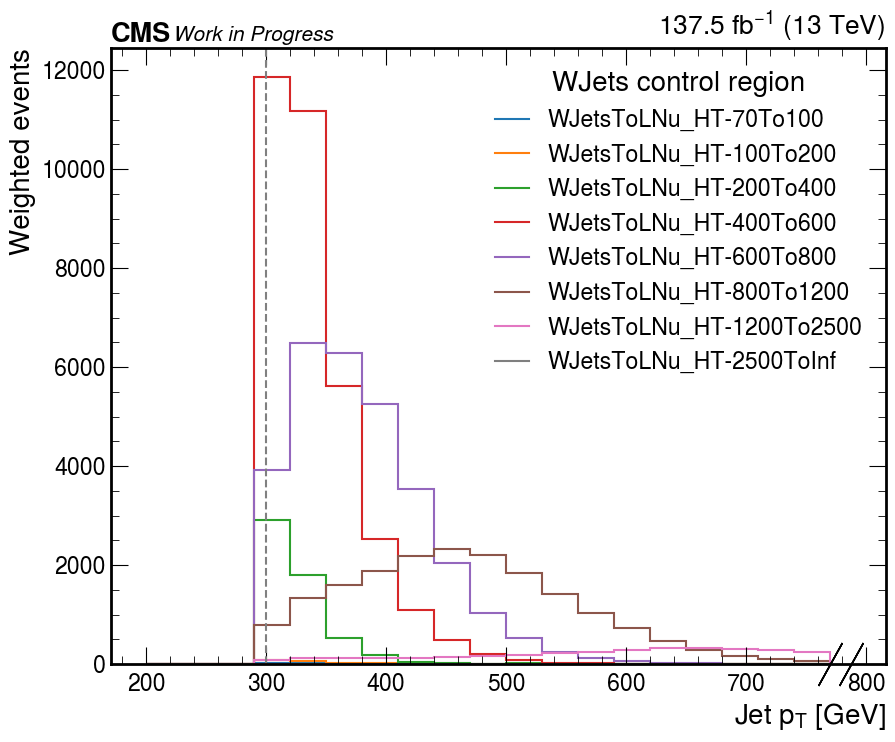

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["nominal"],
                )

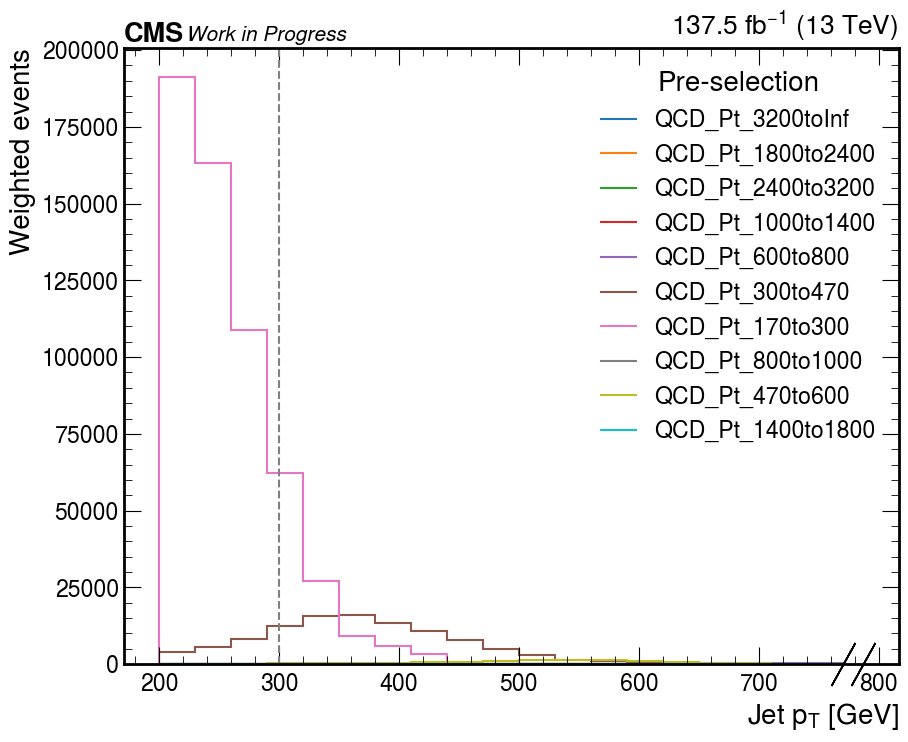

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["nominal"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["nominal"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["nominal"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["nominal"].sum()
                num_sig[sample] += df["nominal"].sum()
            else:
                deno_bkg += df["nominal"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["nominal"].sum()
                else:
                    num_bkg["Others"] += df["nominal"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["nominal"].sum()
            else:
                b += df["nominal"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

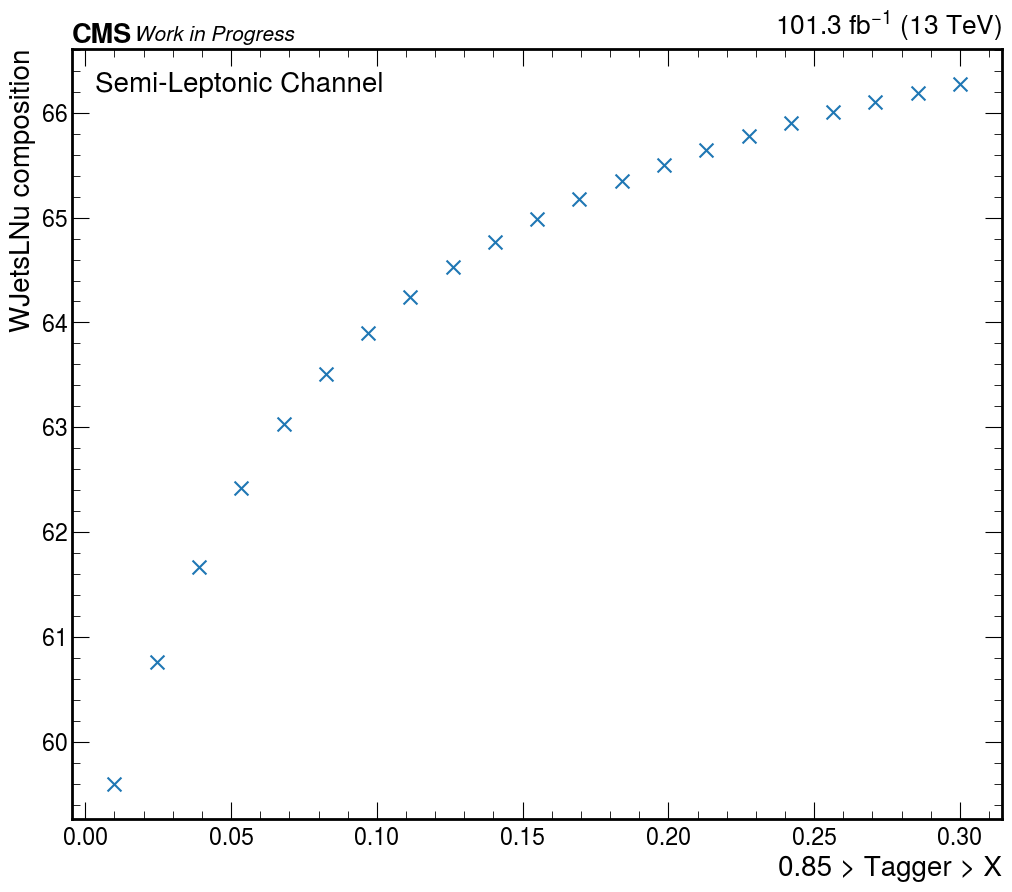

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

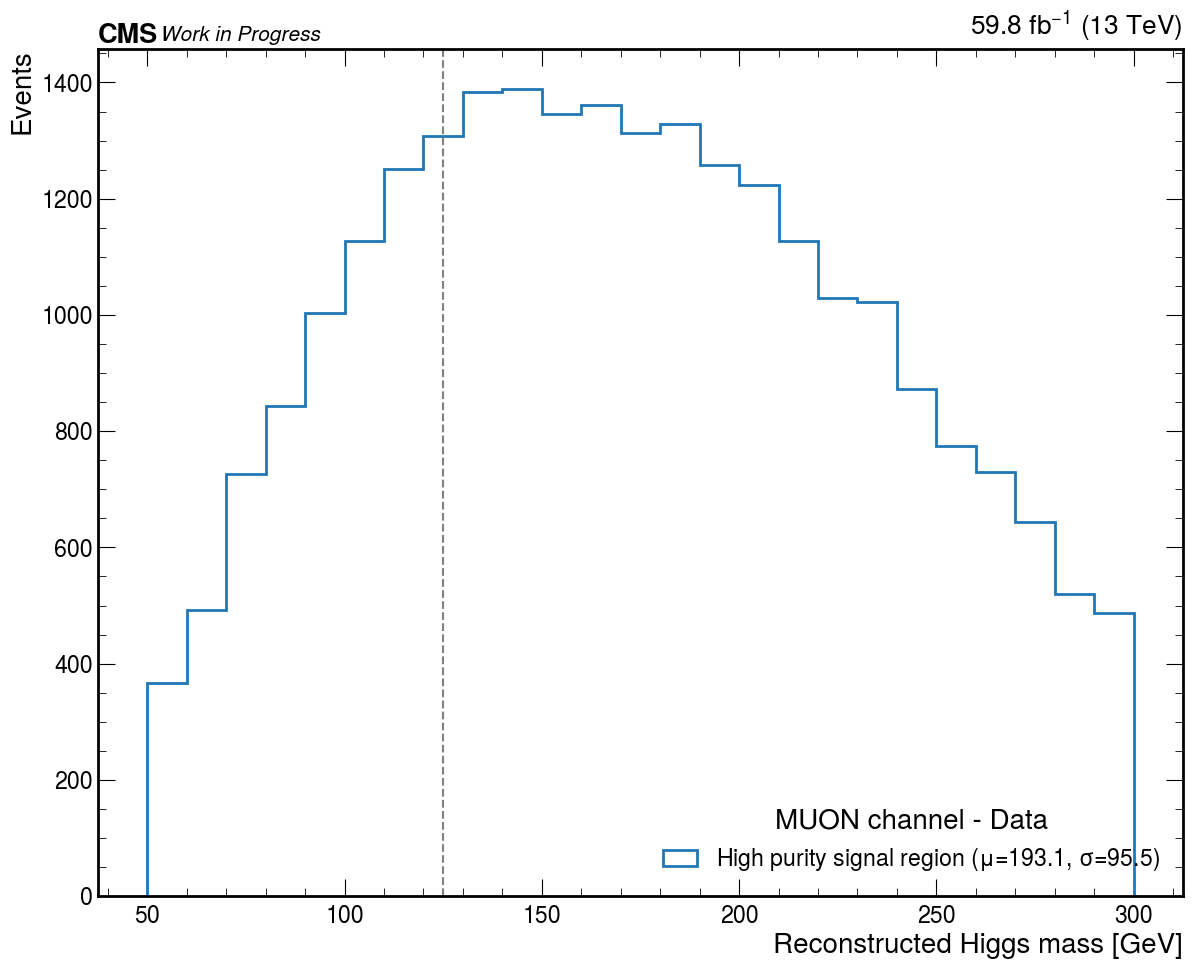

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


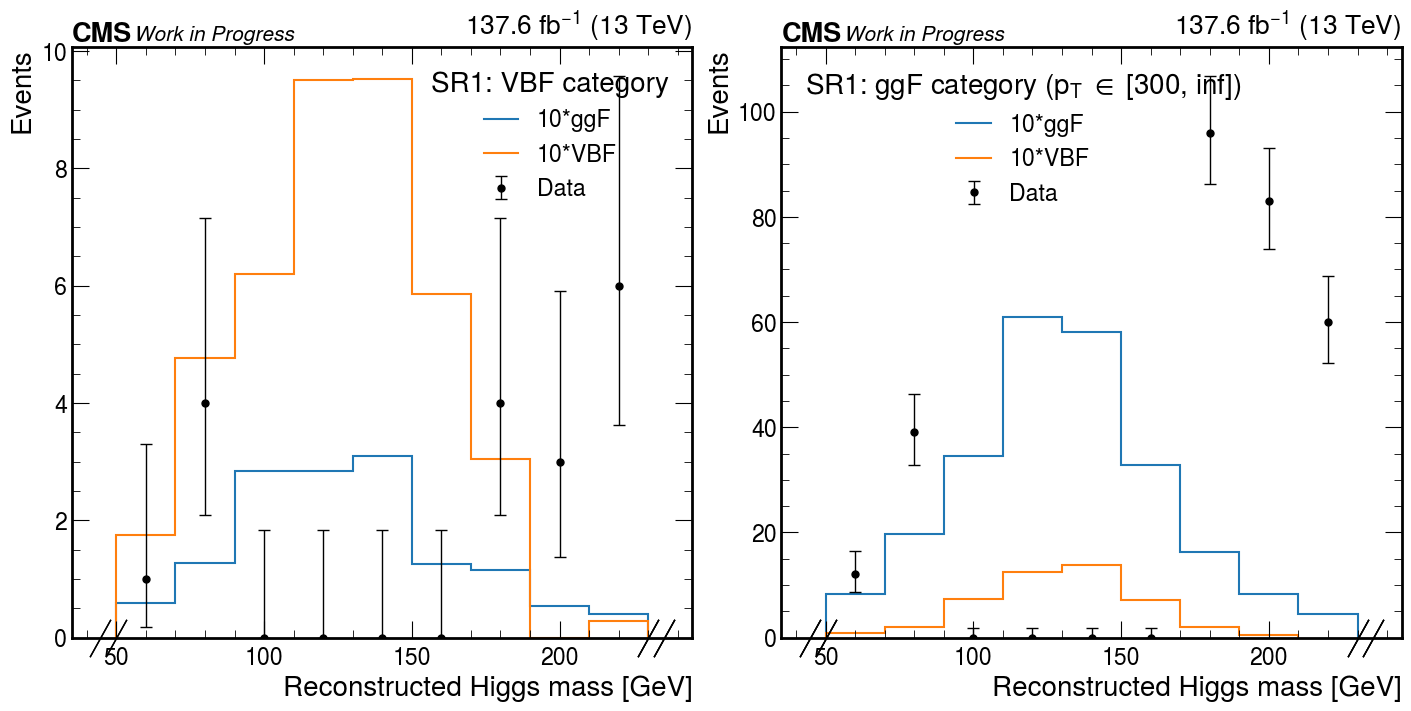

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


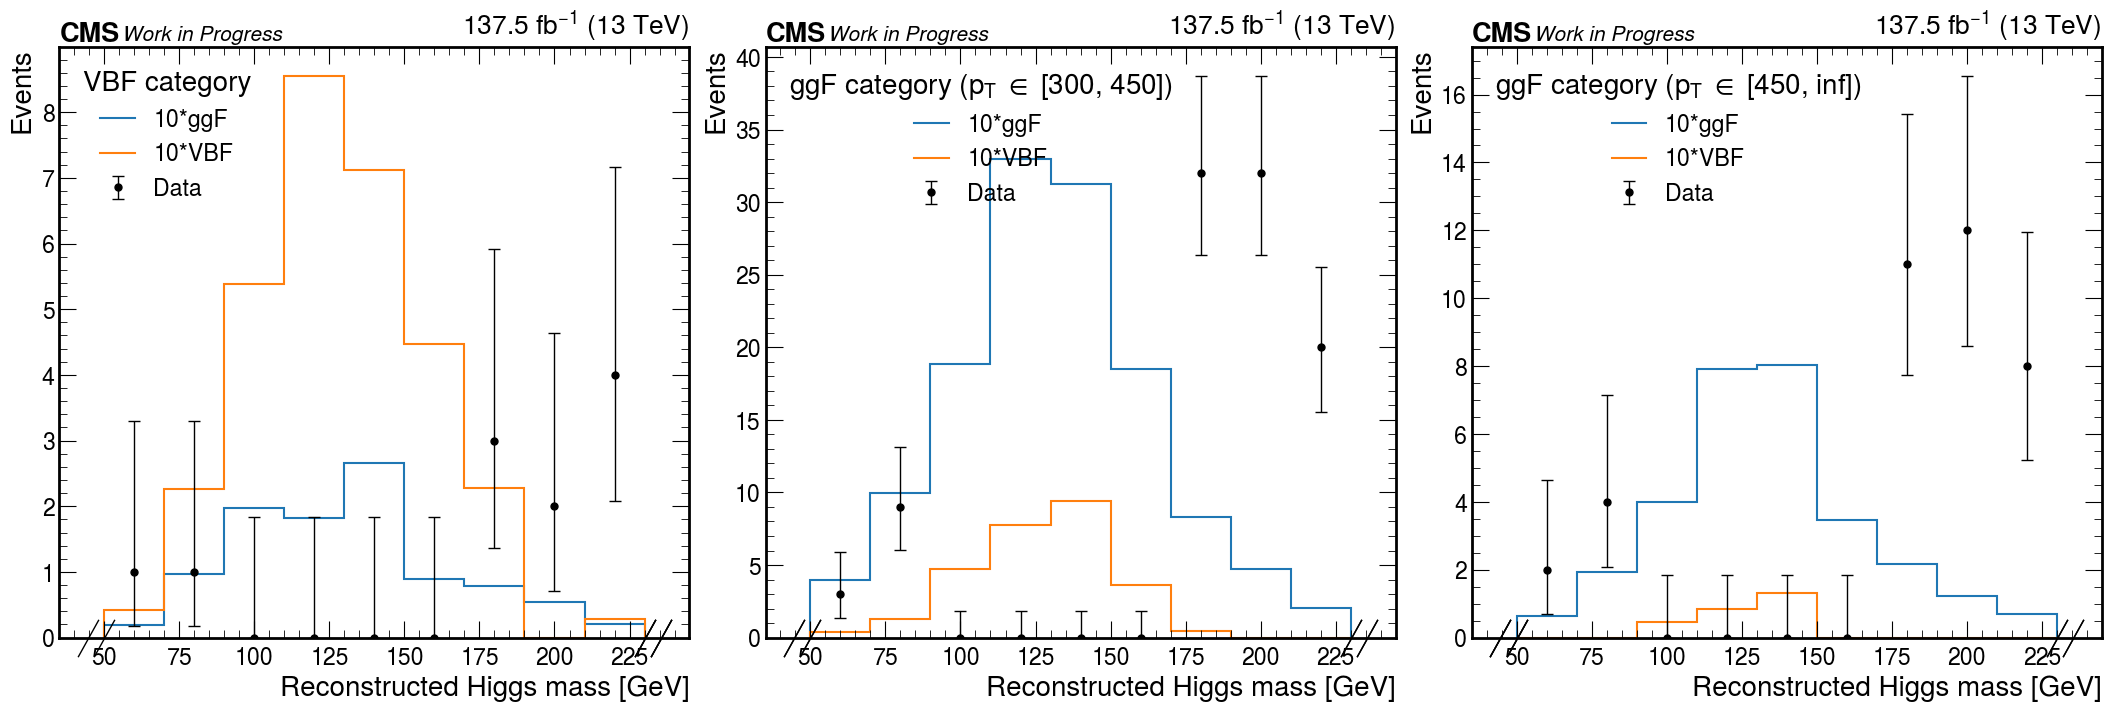

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


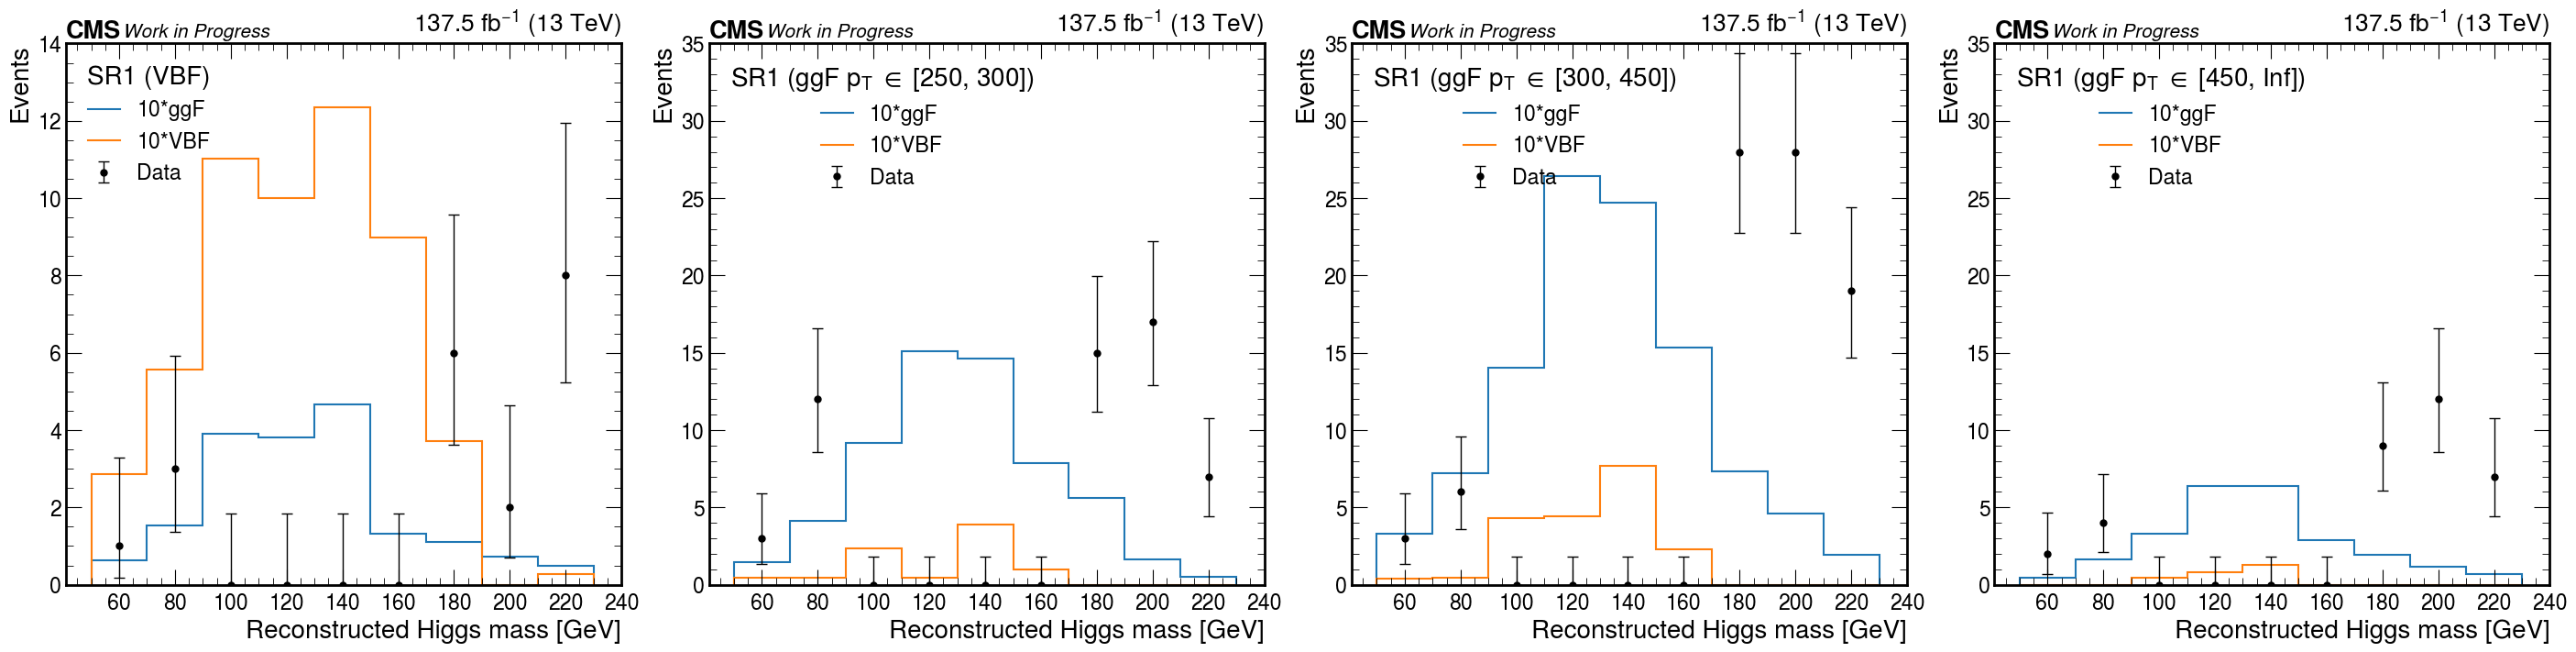

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

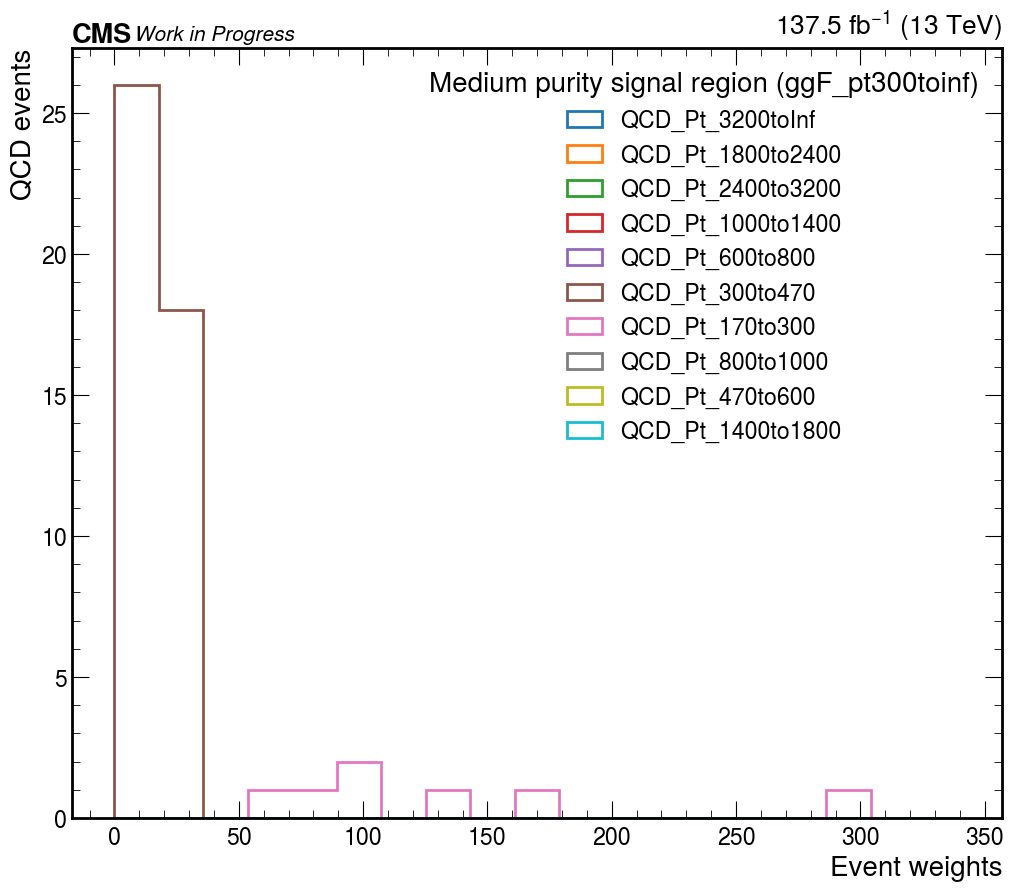

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [441]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()

    print(tot_err_MC)
    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    
    
    
    
    
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [442]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

KeyError: 'signal_region'

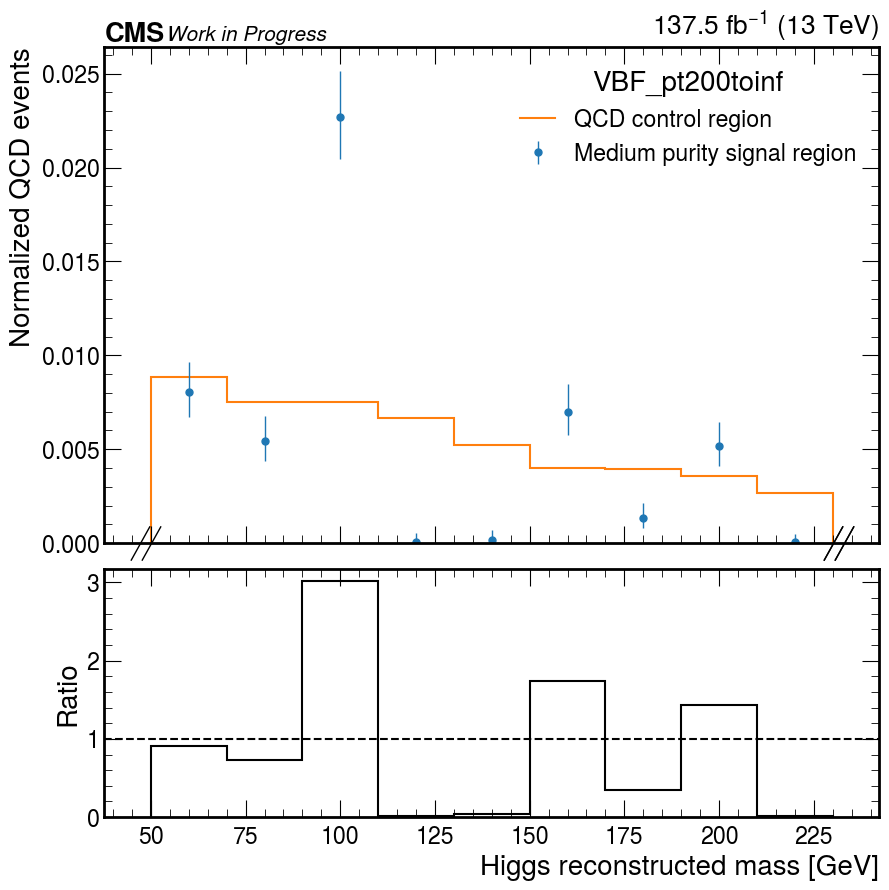

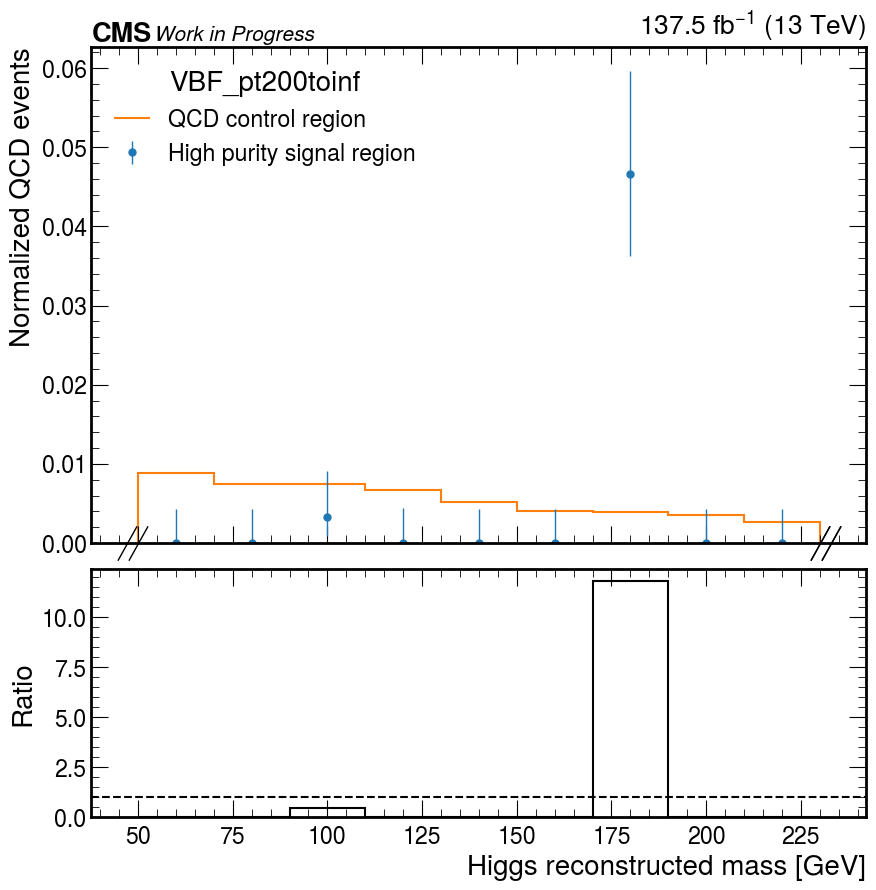

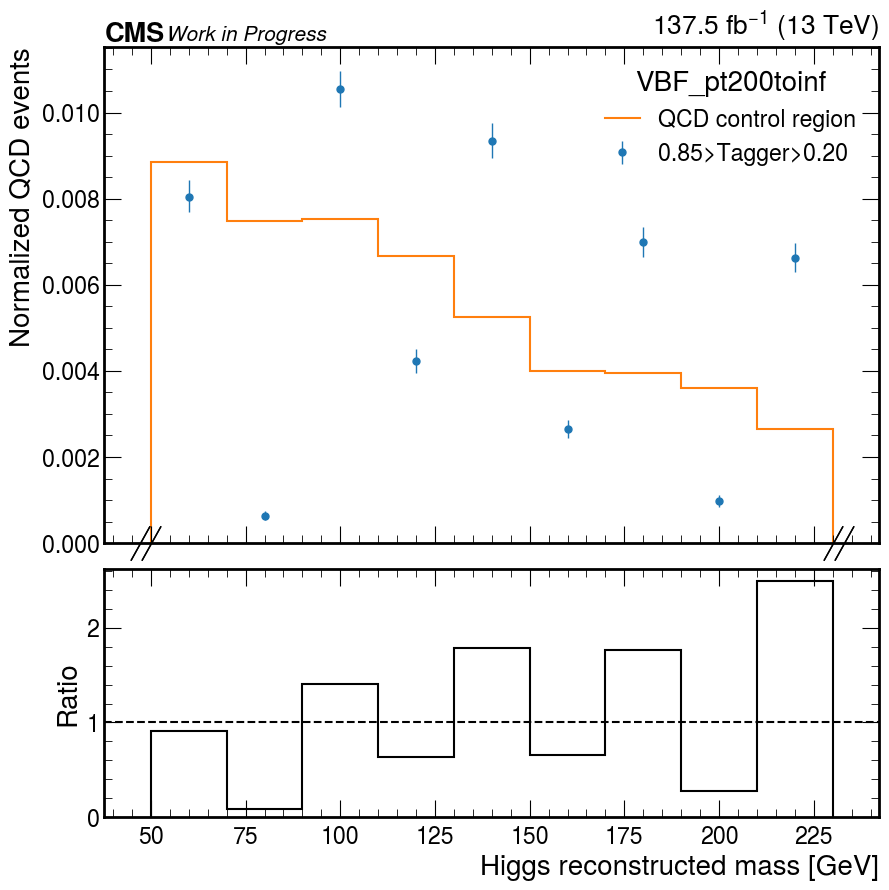

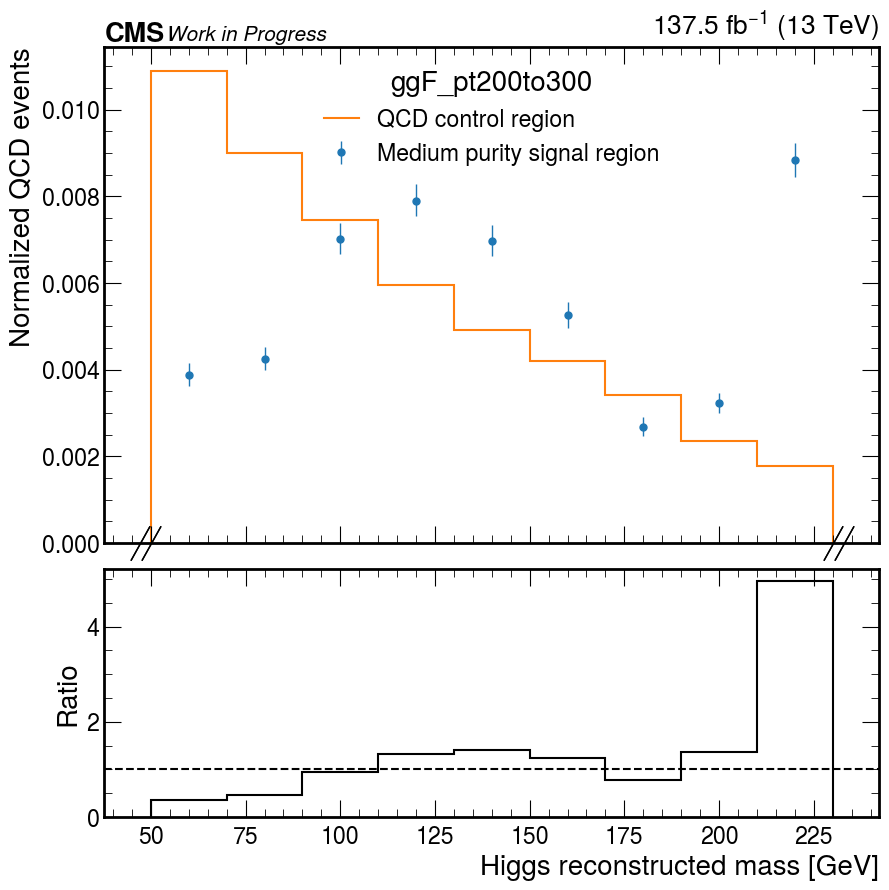

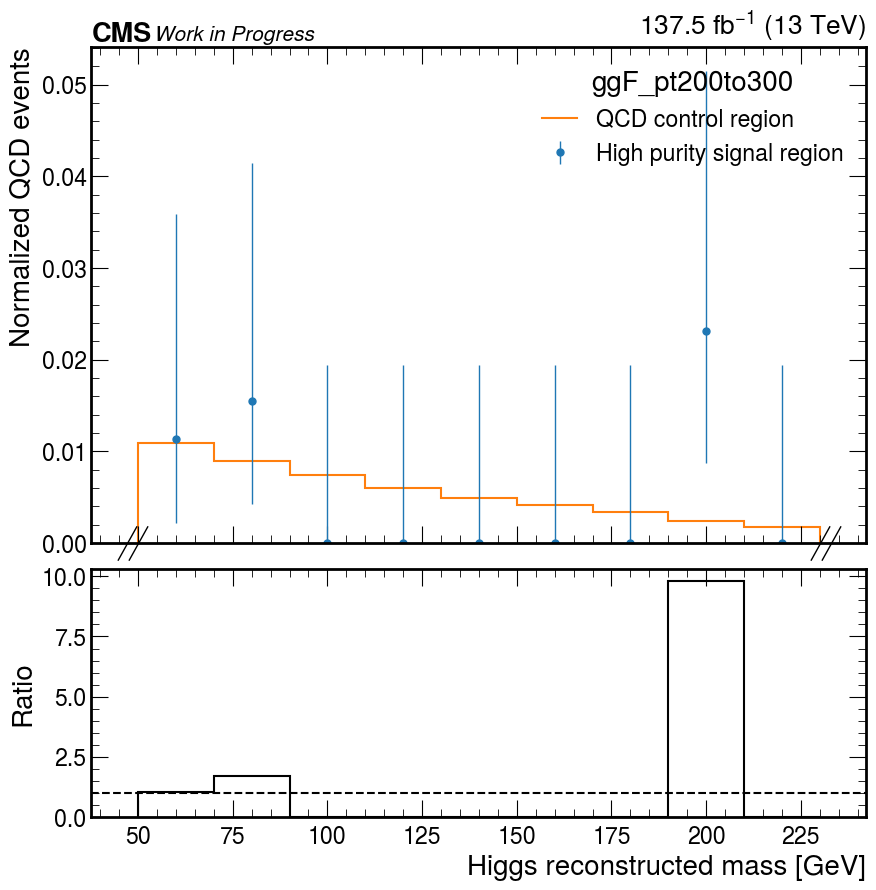

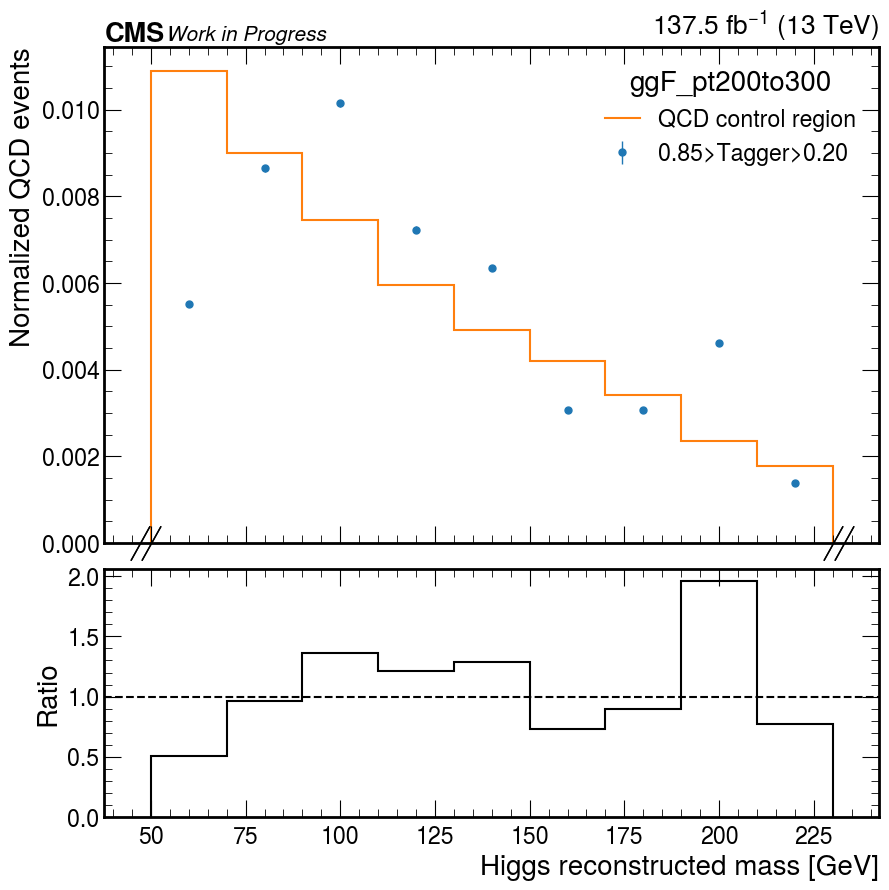

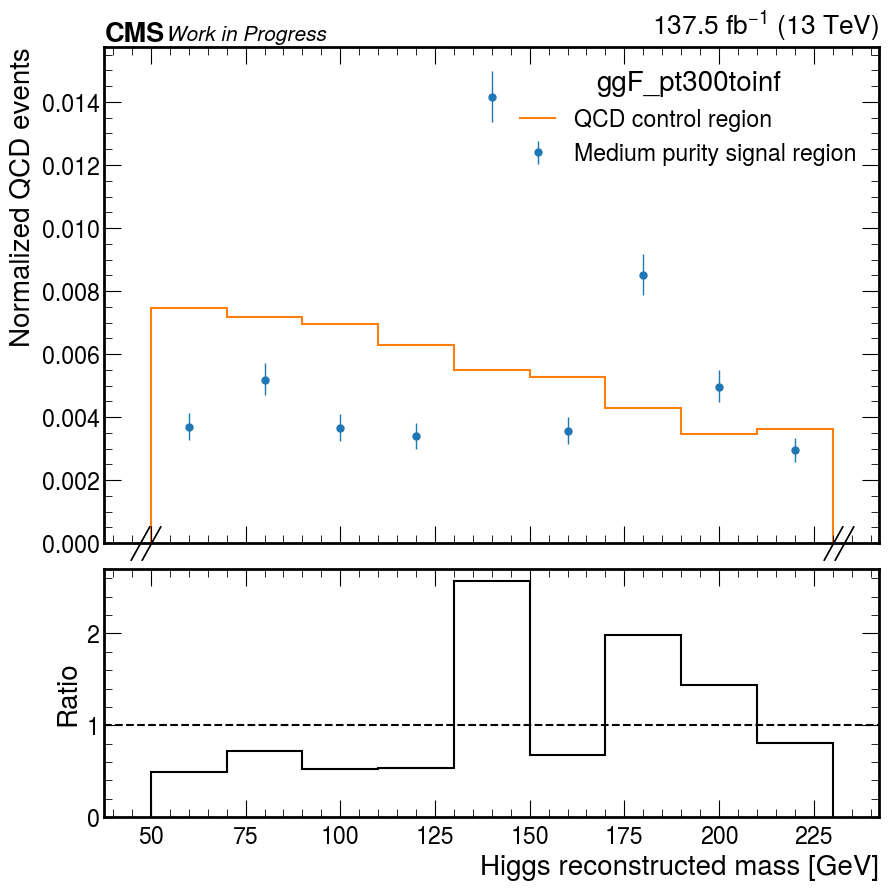

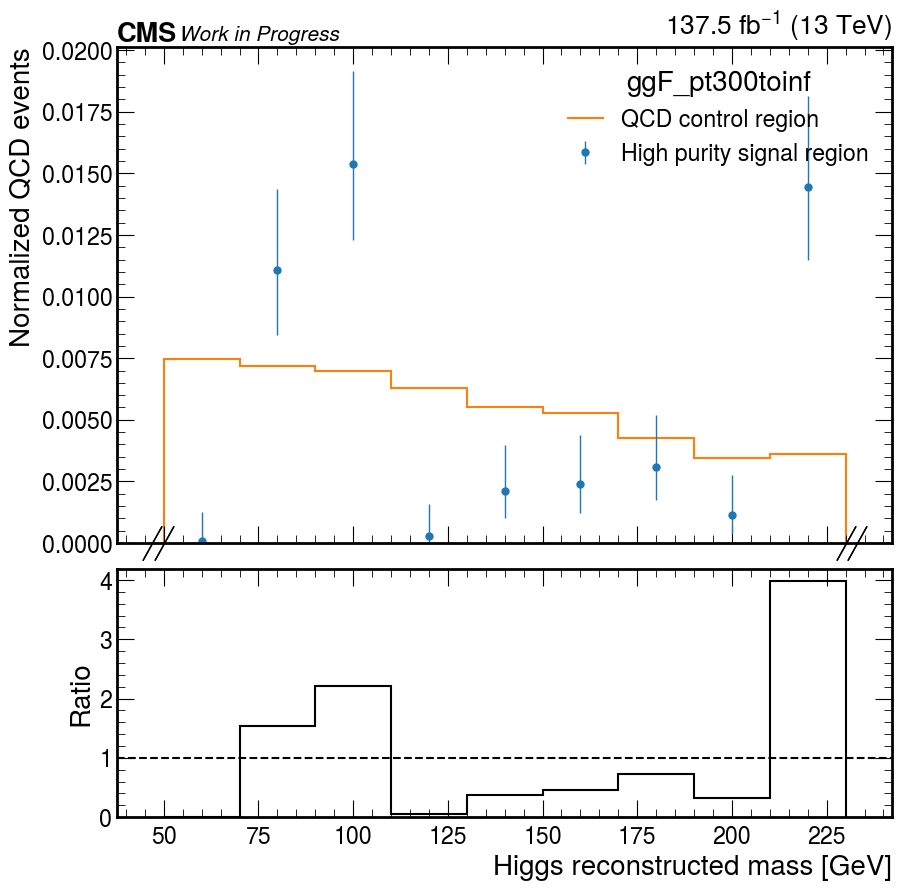

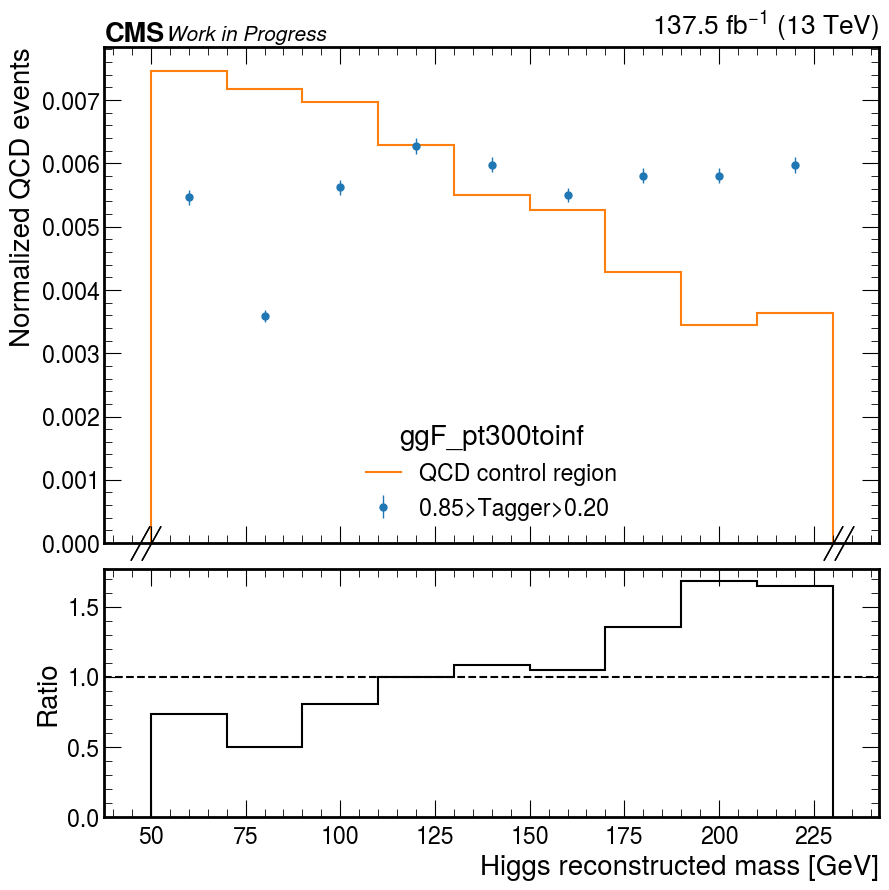

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

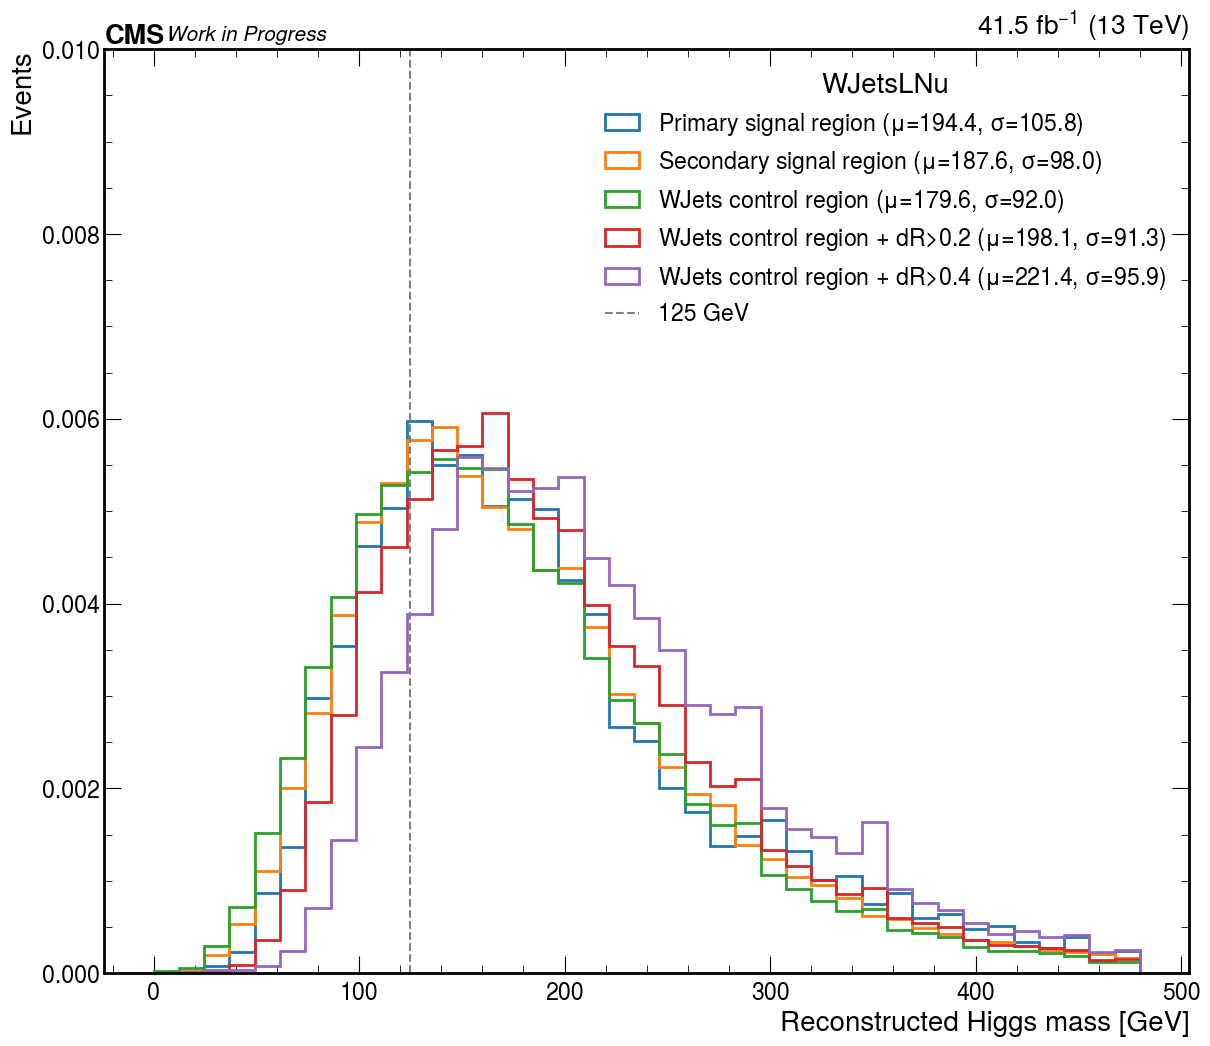

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  